<a href="https://colab.research.google.com/github/mkotemp/kaggle_housingprice/blob/main/wk5_kaggle_ameshousing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Housing price - Kaggle competition data

This notebook was for the housing price competition on the Kaggle website. I am working on this as part of a 6-8 week team project with DataPhilly

Author: Marianne O'Connor
Creation Date: 202501


In [441]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

#0. import python libraries

In [442]:
import numpy as np
import pandas as pd
import matplotlib as plt
import graphviz
import matplotlib.pyplot as plt
import re

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from numpy import random
from sklearn.metrics import mean_squared_error

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification

import xgboost as xgb
from xgboost import XGBClassifier

In [443]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

#1. read housing price training dataset into pandas dataframe

In [444]:
#read in the csv file
try:
  house_df=pd.read_csv("/kaggle/input/home-data-for-ml-course/train.csv")
except:
  from google.colab import drive
  drive.mount('/content/gdrive')
  house_df=pd.read_csv("gdrive/MyDrive/home-data-for-ml-course/train.csv")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#2. split into train and valid datasets

In [445]:
from numpy import random
from sklearn.model_selection import train_test_split

random.seed(42)
trn_df,val_df = train_test_split(house_df, test_size=0.25)
#trn_df[cats] = trn_df[cats].apply(lambda x: x.cat.codes)
#val_df[cats] = val_df[cats].apply(lambda x: x.cat.codes)

#3. review train dataset - EDA


In [446]:
#print(trn_df)
trn_df.describe()
print(trn_df.count())
trn_df.info()

Id               1095
MSSubClass       1095
MSZoning         1095
LotFrontage       895
LotArea          1095
Street           1095
Alley              70
LotShape         1095
LandContour      1095
Utilities        1095
LotConfig        1095
LandSlope        1095
Neighborhood     1095
Condition1       1095
Condition2       1095
BldgType         1095
HouseStyle       1095
OverallQual      1095
OverallCond      1095
YearBuilt        1095
YearRemodAdd     1095
RoofStyle        1095
RoofMatl         1095
Exterior1st      1095
Exterior2nd      1095
MasVnrType        456
MasVnrArea       1091
ExterQual        1095
ExterCond        1095
Foundation       1095
BsmtQual         1068
BsmtCond         1068
BsmtExposure     1068
BsmtFinType1     1068
BsmtFinSF1       1095
BsmtFinType2     1068
BsmtFinSF2       1095
BsmtUnfSF        1095
TotalBsmtSF      1095
Heating          1095
HeatingQC        1095
CentralAir       1095
Electrical       1094
1stFlrSF         1095
2ndFlrSF         1095
LowQualFin

Electrical         1
MasVnrArea         4
BsmtCond          27
BsmtExposure      27
BsmtFinType1      27
BsmtQual          27
BsmtFinType2      27
GarageType        58
GarageQual        58
GarageFinish      58
GarageCond        58
GarageYrBlt       58
LotFrontage      200
FireplaceQu      512
MasVnrType       639
Fence            877
Alley           1025
MiscFeature     1052
PoolQC          1089
dtype: int64


<Axes: >

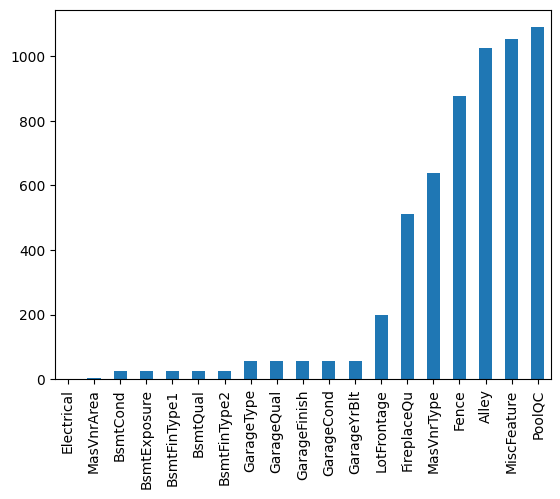

In [447]:
missing = trn_df.isnull().sum()
missing = missing[missing > 0]
missing.sort_values(inplace=True)
print(missing)
missing.plot.bar()

In [448]:
%%capture cap  --no-stderr

#print(trn_df)
trn_df.describe()
print(trn_df.count())
trn_df.info()

# Save the captured output to a text file
try:
  with open('/kaggle/working/output.txt', 'w') as file:
    file.write(cap.stdout)
except:
  with open('gdrive/MyDrive/output.txt', 'w') as file:
    file.write(cap.stdout)

In [449]:
print('Sample fields:')
for fld in ["MSSubClass","PoolQC","MiscFeature","Alley",
             "Fence","MasVnrType","FireplaceQu","LotFrontage"]:
    print(trn_df[fld].value_counts())

Sample fields:
MSSubClass
20     404
60     225
50     106
120     63
70      52
30      47
160     46
80      43
90      37
190     26
75      14
85      14
45       9
180      7
40       2
Name: count, dtype: int64
PoolQC
Fa    2
Ex    2
Gd    2
Name: count, dtype: int64
MiscFeature
Shed    40
Othr     1
Gar2     1
TenC     1
Name: count, dtype: int64
Alley
Grvl    44
Pave    26
Name: count, dtype: int64
Fence
MnPrv    119
GdPrv     47
GdWo      43
MnWw       9
Name: count, dtype: int64
MasVnrType
BrkFace    345
Stone       99
BrkCmn      12
Name: count, dtype: int64
FireplaceQu
Gd    286
TA    236
Fa     26
Ex     19
Po     16
Name: count, dtype: int64
LotFrontage
60.0     105
70.0      54
80.0      51
50.0      46
75.0      39
65.0      34
85.0      29
78.0      19
90.0      19
21.0      17
63.0      15
68.0      14
72.0      14
24.0      14
73.0      13
74.0      13
43.0      12
55.0      11
40.0      11
51.0      11
64.0      11
79.0      11
100.0     10
82.0      10
57.0       9

# lets try out automated EDA


#!pip install autoviz
from autoviz.AutoViz_Class import AutoViz_Class
AV = AutoViz_Class()

filename = "train.csv"
mydf=trn_df
target_variable = "SalePrice"
custom_plot_dir = "~/dataphilly/kaggle_housing_price/eda_output/"
df = AV.AutoViz(mydf,
    sep=",",
    depVar=target_variable,
    dfte=None,
    header=0,
    verbose=1,
    lowess=False,
    chart_format="svg",
    max_rows_analyzed=150000,
    max_cols_analyzed=80,
    save_plot_dir=custom_plot_dir)

#this didn't work
import pandas_profiling as pp
pp.ProfileReport(trn_df)

In [450]:
#Installation

!pip install sweetviz

In [451]:
sv_df=trn_df.copy()
sv_df["Log_SalePrice"]=np.log(sv_df["SalePrice"])
#
#import sweetviz as sv
#my_report = sv.analyze(sv_df,target_feat="Log_SalePrice",)
#my_report.show_notebook()
#try:
#  my_report.show_html('/kaggle/working/sweetviz_input_train_report.html')
#except:
#  my_report.show_html('gdrive/MyDrive/sweetviz_input_train_report.html')

in theory, validation shouldn't be looked at while model building. but here is comparison of original validation/train datasets (before feature engineering). just to help diagnose issues


In [452]:
sv_v_df=val_df.copy()
sv_v_df["Log_SalePrice"]=np.log(sv_v_df["SalePrice"])

import sweetviz as sv
#my_report = sv.analyze(sv_v_df,target_feat="Log_SalePrice",)


#my_report2 = sv.compare([sv_df, "Train"], [sv_v_df, "Validation"], target_feat="Log_SalePrice")
#my_report2.show_notebook()

#try:
#  my_report2.show_html('/kaggle/working/sweetviz_input_train_valdtn_report.html')
#except:
#  my_report2.show_html('gdrive/MyDrive/sweetviz_input_train_valdtn_report.html')



```

```

# 4. Feature Engineering - make into format for modeling


# 4.a prelim work for feature engineering section

In [453]:
#make a dictionary, with column name as the key, and column category as the value
colnames=trn_df.columns

In [454]:
print(colnames)
myseries=colnames
print(myseries)
print(myseries.dtype)
print(myseries[1])

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [455]:
catdict=dict(
Id="unique",
MSSubClass="cat",
MSZoning="cat",
LotFrontage="numeric",
LotArea="numeric",
Street="cat",
Alley="cat",
LotShape="cat",
LandContour="cat",
Utilities="cat",
LotConfig="cat",
LandSlope="cat",
Neighborhood="cat",
Condition1="cat",
Condition2="cat",
BldgType="cat",
HouseStyle="cat",
OverallQual="rank",
OverallCond="rank",
YearBuilt="date",
YearRemodAdd="date",
RoofStyle="cat",
RoofMatl="cat",
Exterior1st="cat",
Exterior2nd="cat",
MasVnrType="cat",
MasVnrArea="numeric",
ExterQual="cat",
ExterCond="cat",
Foundation="cat",
BsmtQual="cat",
BsmtCond="cat",
BsmtExposure="cat",
BsmtFinType1="cat",
BsmtFinSF1="numeric",
BsmtFinType2="cat",
BsmtFinSF2="numeric",
BsmtUnfSF="numeric",
TotalBsmtSF="numeric",
Heating="cat",
HeatingQC="cat",
CentralAir="cat",
Electrical="cat",
_1stFlrSF="numeric",
_2ndFlrSF="numeric",
LowQualFinSF="numeric",
GrLivArea="numeric",
BsmtFullBath="numeric",
BsmtHalfBath="numeric",
FullBath="numeric",
HalfBath="numeric",
BedroomAbvGr="numeric",
KitchenAbvGr="numeric",
KitchenQual="cat",
TotRmsAbvGrd="numeric",
Functional="cat",
Fireplaces="numeric",
FireplaceQu="cat",
GarageType="cat",
GarageYrBlt="numeric",
GarageFinish="cat",
GarageCars="numeric",
GarageArea="numeric",
GarageQual="cat",
GarageCond="cat",
PavedDrive="cat",
WoodDeckSF="numeric",
OpenPorchSF="numeric",
EnclosedPorch="numeric",
_3SsnPorch="numeric",
ScreenPorch="numeric",
PoolArea="numeric",
PoolQC="cat",
Fence="cat",
MiscFeature="cat",
MiscVal="numeric",
MoSold="cat",
YrSold="cat",
SaleType="cat",
SaleCondition="cat"
#,
#"SalePrice"="numeric",
)
print(catdict["SaleCondition"])

cat


In [456]:
#make a lists for all types of fields
uniqlist=[]
catlist=[]
numlist=[]
ranklist=[]
datelist=[]
otherlist=[]
for mykey,myvalue in catdict.items():
    if myvalue=="numeric":
        numlist.append(mykey)
    elif myvalue=="cat":
        catlist.append(mykey)
    elif myvalue=="rank":
        ranklist.append(mykey)
    elif myvalue=="date":
        datelist.append(mykey)
    elif myvalue=="unique":
        uniqlist.append(mykey)
    else:
        otherlist.append(mykey)
print('1.',numlist)
print('2.',catlist)
print('3.',ranklist)
print('4.',datelist)
print('5.',uniqlist)
print('6.',otherlist)

1. ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '_1stFlrSF', '_2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '_3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
2. ['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'MoSold', 'YrSold'

In [457]:
#from numpy import random
#from sklearn.model_selection import train_test_split

#random.seed(42)
#trn_df,val_df = train_test_split(house_df, test_size=0.25)

# 4.b actual beginning of field creation

In [458]:
train=pd.DataFrame()

#drop fields that are mostly made up of missings
drop_majnulls=["Alley", "MasVnrType","FireplaceQu",
               "PoolQC","MiscFeature","Fence"]
#do this for numeric fields
fillna_minornulls=["LotFrontage","MasVnrArea","GarageYrBlt"]
#categorical fields with nulls - see if have dummies for this?
missing_dummies=["BsmtQual","BsmtCond","BsmtExposure",
                    "BsmtFinType1","BsmtFinType2",
                    "Electrical","GarageType",
                    "GarageFinish",
                    "GarageQual","GarageCond"]

In [459]:
#redo the values that I am interested in having dummies on
#trn_df['MSZoning'] = pd.Categorical(trn_df['MSZoning'])
#trn_df['MSZoning'] =pd.Categorical(trn_df['MSZoning']).rename_categories( {'A':"Other",
#          'C (all)':"Other", 'I':"Other",'RH':'Other','RP':'Other' })
# Define a mapping function for regrouping
#def regroup(category):
#    if category in ['A', 'C (all)','I','RH','RP']:
#        return 'Other'
#    else:
#        return category
# Regroup categories
#trn_df['MSZoning'] = trn_df['MSZoning'].map(regroup)


# Sample DataFrame
# Categories to combine into 'Other'
#categories_to_combine = ['A', 'C (all)','I','RH','RP']
# Combine categories

#get rid of certain values - regroup
#MSSubCLass - 180, 190,40, 45, 75, 85
#trn_df["MSSubClass"] = trn_df["MSSubClass"].replace([40,45,75,85,180,190], 'Other')
trn_df["MSSubClass"] = pd.Categorical(trn_df['MSSubClass'], categories=[20,30,50,60,70,80,90,120,150,160])
#utlities_nan

#Condition2_Feedr
#YRSold - make dummies
trn_df['Age_when_sold']=trn_df['YrSold'] - trn_df['YearBuilt']
trn_df['Age_eq0_new_flag']=trn_df['Age_when_sold']<1
trn_df['Age_tens_clipped']=(trn_df['Age_when_sold']//10*10).clip(upper=60)
trn_df['Age_gt60_flag']=trn_df['Age_when_sold']>60

trn_df['Years_untilsold_after_remodel'] = trn_df['YrSold'] - trn_df['YearRemodAdd']
trn_df['Age_at_remodel'] = trn_df['YearRemodAdd'] - trn_df['YearBuilt']
trn_df['Remodeled_flag'] = trn_df['Age_at_remodel']>1

trn_df['YrSold'] = pd.Categorical(trn_df['YrSold'])


trn_df["MSZoning"] = trn_df["MSZoning"].replace(['A', 'C (all)','I','RH','RP'], 'Other')
print(trn_df['MSZoning'].unique())
trn_df["RoofStyle"] = trn_df["RoofStyle"].replace(['Flat','Gambrel','Mansard','Shed'], 'Other')
trn_df['Foundation'] = trn_df["Foundation"].replace(['BrkTil','Slab','Stone','Wood'], 'Other')
trn_df['BsmtFinType1'] = trn_df["BsmtFinType1"].replace(['Rec','LwQ'], 'Other')
trn_df['GarageType'] = trn_df["GarageType"].replace(['2Types','Basment','CarPort'], 'Other')
trn_df['SaleType'] = trn_df["SaleType"].replace(['CWD','VWD','Con','ConLw','ConLI','ConLD','Oth'],'Other')
trn_df['SaleCondition'] = trn_df["SaleCondition"].replace(['AdjLand','Family','Alloc' ],'Other')



trn_df['LotShape'] = pd.Categorical(trn_df['LotShape'], categories=['Reg', 'IR1','Ir2'])
trn_df['LandContour'] = pd.Categorical(trn_df['LandContour'], categories=['Lvl'])
trn_df['LotConfig'] = pd.Categorical(trn_df['LotConfig'], categories=['Inside','Corner','CulDSac'])
trn_df['Neighborhood'] = pd.Categorical(trn_df['Neighborhood'], categories=['NAmes','OldTOwn','Edwards'])
trn_df['Condition1'] = pd.Categorical(trn_df['Condition1'], categories=['Norm','Feedr','Artery'])
trn_df['Condition2'] = pd.Categorical(trn_df['Condition2'], categories=['Norm'])
trn_df['HouseStyle'] = pd.Categorical(trn_df['HouseStyle'], categories=['1Story','2Story','1.5Fin'])
trn_df['RoofMatl'] = pd.Categorical(trn_df['RoofMatl'], categories=['CompShg'])
trn_df['Exterior1st'] = pd.Categorical(trn_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
trn_df['Exterior2nd'] = pd.Categorical(trn_df['Exterior2nd'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
trn_df['BedroomAbvGr'] = pd.Categorical(trn_df['BedroomAbvGr'], categories=[1,2,3,4])
trn_df['KitchenAbvGr'] = pd.Categorical(trn_df['KitchenAbvGr'], categories=[1,2])
trn_df['Functional'] = pd.Categorical(trn_df['Functional'], categories=['Typ'])
trn_df['Fireplaces'] = pd.Categorical(trn_df['Fireplaces'], categories=[0,1,2])
trn_df['GarageCars'] = pd.Categorical(trn_df['GarageCars'], categories=[0,1,2,3])



trn_df['Exterior1st'] = pd.Categorical(trn_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
trn_df['Heating'] = pd.Categorical(trn_df['Heating'], categories=['GasA'])
trn_df['Electrical'] = pd.Categorical(trn_df['Electrical'], categories=['SBrkr','FuseA'])
trn_df['ExterCond'] = pd.Categorical(trn_df['ExterCond'], categories=['TA','Gd','Ex'])
trn_df['GarageCond'] = pd.Categorical(trn_df['GarageCond'], categories=['TA'])
trn_df['GarageQual'] = pd.Categorical(trn_df['GarageQual'], categories=['TA'])
trn_df['HeatingQC'] = pd.Categorical(trn_df['HeatingQC'], categories=['TA','Gd','Ex'])
trn_df['Utilities'] = pd.Categorical(trn_df['Utilities'], categories=['AllPub'])


#'Other' category
def makeother(mydf,categorical_series):
  # Add a default category
  catsrs=mydf[categorical_series]
  catsrs = catsrs.cat.add_categories('Other')
  # Replace values not in the specified categories with 'Other'
  catsrs = catsrs.fillna('Other')
  return catsrs


listcat=['LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','HouseStyle','RoofMatl','Exterior1st','Exterior2nd',
  'BedroomAbvGr','KitchenAbvGr','Functional','Fireplaces','Exterior1st','Heating','Electrical','ExterCond','GarageCond','GarageQual',
  'HeatingQC','Utilities','MSSubClass']

for cat in listcat:
  makeother(trn_df,cat)
print(trn_df['LotShape'].unique())

#Condition2 --
#Electrical
#ExterCond  - TA
#GarageCond - TA
#GarageQual - TA
#Heating
#HeatingQC - TA

#Condition2
#Electrical
#ExterCond - TA
#Exterior1st
#GarageCond - TA
#GarageQual - TA
#Heating
#HeatingQC - TA


#['Utilities_NoSeWa', 'Condition2_Artery', 'GarageQual_Ex', 'GarageCond_Ex', 'GarageCond_Gd']

['RL' 'RM' 'FV' 'Other']
['Reg', 'IR1', NaN]
Categories (3, object): ['Reg', 'IR1', 'Ir2']


In [460]:
for field in catdict:
    if catdict[field]=="cat" and (field not in drop_majnulls):
#        if field in missing_dummies:
#             dummies_class = pd.get_dummies(trn_df[field].astype('str'),prefix=field, dummy_na=True) #leave all  classes for now, though one is redundant
#        else:
        dummies_class = pd.get_dummies(trn_df[field].astype('str'),prefix=field) #don't make dummy class if no nulls
        train = pd.concat([train, dummies_class], axis=1)
    elif catdict[field] in ["numeric","rank","date","unique"] and (field not in drop_majnulls):
         if field[0]=='_':
             field=field[1:]
             print(field)
         fields_asis=trn_df[field]
         train = pd.concat([train, fields_asis], axis=1)

train['Age_when_sold']=trn_df['Age_when_sold']

train['Age_eq0_new_flag']=trn_df['Age_eq0_new_flag']
train['Age_tens_clipped']=trn_df['Age_tens_clipped']
train['Age_gt60_flag']=trn_df['Age_gt60_flag']

train['Years_untilsold_after_remodel'] = trn_df['Years_untilsold_after_remodel']
train['Age_at_remodel'] = trn_df['Age_at_remodel']
train['Remodeled_flag'] = trn_df['Remodeled_flag']


train["Log_SalePrice"]=np.log(trn_df["SalePrice"])
print( train["Log_SalePrice"].head(5), trn_df["SalePrice"].head(5))


1stFlrSF
2ndFlrSF
3SsnPorch
1023    12.160029
810     12.106252
1384    11.561716
626     11.848683
813     11.969717
Name: Log_SalePrice, dtype: float64 1023    191000
810     181000
1384    105000
626     139900
813     157900
Name: SalePrice, dtype: int64


In [461]:
print(train.head(5))
print("\n 1Describe:",train.describe(),"\n")
print("2Info:")
train.info()
colnames_train=train.columns
print("3Cols:",colnames_train)
print(train["LotFrontage"].iloc[5])

        Id  MSSubClass_120  MSSubClass_160  MSSubClass_20  MSSubClass_30  \
1023  1024            True           False          False          False   
810    811           False           False           True          False   
1384  1385           False           False          False          False   
626    627           False           False           True          False   
813    814           False           False           True          False   

      MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_80  \
1023          False          False          False          False   
810           False          False          False          False   
1384           True          False          False          False   
626           False          False          False          False   
813           False          False          False          False   

      MSSubClass_90  MSSubClass_nan  MSZoning_FV  MSZoning_Other  MSZoning_RL  \
1023          False           False        False     

In [462]:
print(trn_df["BsmtQual"].isnull().sum())
print(trn_df[["Id","BsmtQual"]][trn_df["BsmtQual"].isnull()])
print('**test record',train[["BsmtQual_TA","BsmtQual_Gd","BsmtQual_Ex","BsmtQual_Fa","BsmtQual_nan"]] [train["Id"]==1049] )

27
        Id BsmtQual
1048  1049      NaN
156    157      NaN
778    779      NaN
705    706      NaN
39      40      NaN
553    554      NaN
1035  1036      NaN
362    363      NaN
533    534      NaN
182    183      NaN
102    103      NaN
1179  1180      NaN
1000  1001      NaN
90      91      NaN
1412  1413      NaN
1090  1091      NaN
868    869      NaN
1011  1012      NaN
17      18      NaN
1218  1219      NaN
749    750      NaN
1045  1046      NaN
1321  1322      NaN
392    393      NaN
520    521      NaN
897    898      NaN
646    647      NaN
**test record       BsmtQual_TA  BsmtQual_Gd  BsmtQual_Ex  BsmtQual_Fa  BsmtQual_nan
1048        False        False        False        False          True


In [463]:
#for missings...just fill in with mode for now
modes = train.mode().iloc[0]
print(modes["LotFrontage"], modes["MasVnrArea"], modes["GarageYrBlt"])
print(fillna_minornulls)
for fld in fillna_minornulls:
    train[fld] = train[fld].fillna(modes[fld])

60.0 0.0 2005.0
['LotFrontage', 'MasVnrArea', 'GarageYrBlt']


In [464]:
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0]
missing_train.sort_values(inplace=True)
print(missing_train)
#missing_train.plot.bar()

KitchenAbvGr     2
GarageCars       2
Fireplaces       3
BedroomAbvGr    23
dtype: int64


In [465]:
#take care of these missings as well - they are artificial missings -think about
#for missings...just fill in with mode for now
modes = train.mode().iloc[0]
print(modes["KitchenAbvGr"], modes["GarageCars"], modes["Fireplaces"],modes['BedroomAbvGr'])
rmndr_fillna=["KitchenAbvGr","GarageCars","Fireplaces",'BedroomAbvGr']
print(rmndr_fillna)
for fld in rmndr_fillna:
    train[fld] = train[fld].fillna(modes[fld])

1 2 0 3
['KitchenAbvGr', 'GarageCars', 'Fireplaces', 'BedroomAbvGr']


In [466]:
#these aren't true missings at this point. they are related to my categorical grouping to reduce categories.
#anything not in my list was set to missing. They got their own 'NA' field when I created dummies.
missing_train = train.isnull().sum()
missing_train = missing_train[missing_train > 0]
missing_train.sort_values(inplace=True)
print(missing_train)
#missing_train.plot.bar()\


Series([], dtype: int64)


In [467]:
print(train.head(5))
print("\n 1.",train.describe(),"\n")
train.info()

        Id  MSSubClass_120  MSSubClass_160  MSSubClass_20  MSSubClass_30  \
1023  1024            True           False          False          False   
810    811           False           False           True          False   
1384  1385           False           False          False          False   
626    627           False           False           True          False   
813    814           False           False           True          False   

      MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_80  \
1023          False          False          False          False   
810           False          False          False          False   
1384           True          False          False          False   
626           False          False          False          False   
813           False          False          False          False   

      MSSubClass_90  MSSubClass_nan  MSZoning_FV  MSZoning_Other  MSZoning_RL  \
1023          False           False        False     

In [468]:
#look at distribution of the boolean features
x = train.select_dtypes(bool)
out = pd.DataFrame({True: x.sum(), False: train.shape[0] - x.sum() })
out["Total"] = x.count()
out["%True"] = x.mean(skipna=True)
out.sort_values(["%True"],inplace=True,ascending=False)
print(out)

                       True  False  Total     %True
Utilities_AllPub       1094      1   1095  0.999087
Street_Pave            1091      4   1095  0.996347
Condition2_Norm        1086      9   1095  0.991781
RoofMatl_CompShg       1076     19   1095  0.982648
Heating_GasA           1070     25   1095  0.977169
LandSlope_Gtl          1036     59   1095  0.946119
CentralAir_Y           1017     78   1095  0.928767
Functional_Typ         1013     82   1095  0.925114
PavedDrive_Y           1004     91   1095  0.916895
Electrical_SBrkr       1002     93   1095  0.915068
GarageCond_TA           995    100   1095  0.908676
LandContour_Lvl         992    103   1095  0.905936
GarageQual_TA           986    109   1095  0.900457
BsmtCond_TA             977    118   1095  0.892237
ExterCond_TA            960    135   1095  0.876712
SaleType_WD             955    140   1095  0.872146
BsmtFinType2_Unf        946    149   1095  0.863927
Condition1_Norm         946    149   1095  0.863927
BldgType_1Fa

#4. look at relationship of features to the target response variable - Log_SalePrice

In [469]:
big_table=pd.DataFrame()
for bools in x:
  table = pd.pivot_table(train, values=["Log_SalePrice"], index=bools,
                       aggfunc= ["count","sum", "mean"])
  print(table)
  big_table=pd.concat([big_table,table],axis=0)
print(big_table)

                       count           sum          mean
               Log_SalePrice Log_SalePrice Log_SalePrice
MSSubClass_120                                          
False                   1032  12406.516829     12.021819
True                      63    767.481731     12.182250
                       count           sum          mean
               Log_SalePrice Log_SalePrice Log_SalePrice
MSSubClass_160                                          
False                   1049  12631.108958     12.041095
True                      46    542.889602     11.801948
                      count           sum          mean
              Log_SalePrice Log_SalePrice Log_SalePrice
MSSubClass_20                                          
False                   691   8303.647078     12.016855
True                    404   4870.351482     12.055325
                      count           sum          mean
              Log_SalePrice Log_SalePrice Log_SalePrice
MSSubClass_30                         

In [470]:
regroup_num_fields=['LotFrontage', 'LotArea', 'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF',
#                    '_1stFlrSF', '_2ndFlrSF',
                    'LowQualFinSF',
                    'GrLivArea','GarageArea','WoodDeckSF',  'OpenPorchSF','EnclosedPorch',
 # '_3SsnPorch',

                    'ScreenPorch',
 #                   'PoolArea',
                    'MiscVal']

for fld in regroup_num_fields:
  #fix the onews that start with '-'
  if fld[0]=='_':
             fld=fld[1:]
  # Calculate the 95th percentile value
  upper_limit = train[fld].quantile(0.95)
  # Clip the values at the 95th percentile
  train[fld+'_clip'] = train[fld].clip(upper=upper_limit)

  mymax=train[fld].max()
  tenths_of_fld=mymax/10
  tenth_ranges=train[fld]//tenths_of_fld
  train[fld+'_grp']=tenth_ranges*tenths_of_fld

  # Rank the values
  train[fld+'_rnk'] = train[fld].rank(method='average')
  # Normalize the ranks to the range 1-10
  train[fld+'_rnk'] = ((train[fld+'_rnk'] - 1) / (train[fld+'_rnk'].max() - 1) * 9 + 1)//1*1 # mko added last two to get integer ranks


#features=['OverallQual','GarageCars','GrLivArea','GarageArea','TotalBsmtSF',
#        'BsmtQual_TA','KitchenQual_TA','ExterQual_TA',
#        'GrLivArea_cap','GrLivArea_grp','GrLivArea_rnk']

#print(train.head(5))


clip_list=['LotFrontage_clip', 'LotArea_clip', 'BsmtFinSF2_clip','BsmtUnfSF_clip','TotalBsmtSF_clip',
            'LowQualFinSF_clip',
            'GrLivArea_clip','GarageArea_clip','WoodDeckSF_clip',  'OpenPorchSF_clip','EnclosedPorch_clip',
            'ScreenPorch_clip',  'MiscVal_clip']
grp_list=['LotFrontage_grp', 'LotArea_grp', 'BsmtFinSF2_grp','BsmtUnfSF_grp','TotalBsmtSF_grp',
            'LowQualFinSF_grp',
            'GrLivArea_grp','GarageArea_grp','WoodDeckSF_grp',  'OpenPorchSF_grp','EnclosedPorch_grp',
            'ScreenPorch_grp',  'MiscVal_grp']
rnk_list=['LotFrontage_rnk', 'LotArea_rnk', 'BsmtFinSF2_rnk','BsmtUnfSF_rnk','TotalBsmtSF_rnk',
            'LowQualFinSF_rnk',
            'GrLivArea_rnk','GarageArea_rnk','WoodDeckSF_rnk',  'OpenPorchSF_rnk','EnclosedPorch_rnk',
            'ScreenPorch_rnk',  'MiscVal_rnk']

print(train.groupby(['LotFrontage_rnk'])["LotFrontage"].mean().reset_index())
print(train.groupby(['LotFrontage_grp'])["LotFrontage"].mean().reset_index())
print(train.groupby(['LotFrontage_clip'])["LotFrontage"].mean().reset_index())
#print(train.groupby(['LotFrontage_clip'])["LotFrontage"].count().reset_index())

   LotFrontage_rnk  LotFrontage
0              1.0    35.026316
1              2.0    52.857143
2              4.0    60.000000
3              5.0    64.037975
4              6.0    70.126050
5              7.0    77.489655
6              8.0    85.841584
7              9.0   108.932203
8             10.0   313.000000
   LotFrontage_grp  LotFrontage
0              0.0    23.594595
1             31.3    55.490119
2             62.6    76.068889
3             93.9   105.107143
4            125.2   140.166667
5            156.5   171.000000
6            281.7   313.000000
    LotFrontage_clip  LotFrontage
0               21.0         21.0
1               24.0         24.0
2               30.0         30.0
3               32.0         32.0
4               34.0         34.0
5               35.0         35.0
6               36.0         36.0
7               37.0         37.0
8               38.0         38.0
9               39.0         39.0
10              40.0         40.0
11              

In [471]:


train['YearBuilt_pre1950_flag']=trn_df['YearBuilt']<1950
train['YearBuilt']=(train['YearBuilt']//10*10).clip(lower=1950)
train['YearBuilt'].unique()
train['YearRemodAdd'] = train['YearRemodAdd']//10*10
train['2ndFlrSF_gt0']= train['2ndFlrSF']>=0
train['FullBath_1']=train['FullBath']==1
train['FullBath_2']=train['FullBath']==2
train['HalfBath_0']=train['HalfBath']==0
train['HalfBath_1']=train['HalfBath']==1
train['BedroomAbvGr_4']=train['BedroomAbvGr']==4
train['BedroomAbvGr_3']=train['BedroomAbvGr']==3
train['BedroomAbvGr_2']=train['BedroomAbvGr']==2

train['Fireplaces_none']=train['Fireplaces']==0
train['Fireplaces_one']=train['Fireplaces']==1
train['Fireplaces_gt0']=train['Fireplaces']!=0

train['WoodDeckSF_gt0']=train['WoodDeckSF']>=0
train['OpenPorchSF_gt0']=train['OpenPorchSF']>=0
train['EnclosedPorch_gt0']=train['EnclosedPorch']>=0
#i dropped pool qc because mostly empty field
train['PoolArea_none'] = train['PoolArea']==0


In [472]:
#do min max scaling for the 4 continuous features that I find end up in model.
#force using them in model selection, and see if they improve things.
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing

# Sample data
#rawdata_features=['GrLivArea_clip','LotArea_clip','BsmtUnfSF_clip','TotalBsmtSF_rnk']
rawdata_features=['GrLivArea','LotArea','BsmtUnfSF','TotalBsmtSF']

# Initialize MinMaxScaler
#scaler = MinMaxScaler()

# Fit and transform the data
#scaled_data = scaler.fit_transform(rawdata_features)


scaler = preprocessing.MinMaxScaler()
#minmax_df = scaler.fit_transform(train[rawdata_features])
# calculate median and IQR
scaler.fit(train[rawdata_features])
# scale all data points using median and IQR
minmax_scaled_data = scaler.transform(train[rawdata_features])
print('**',minmax_scaled_data,'**')
minmax_df = pd.DataFrame(minmax_scaled_data, columns =['GrLivArea_minmax', 'LotArea_minmax','BsmtUnfSF_minmax','TotalBsmtSF_minmax'])
# Apply df1's index to df2
minmax_df.index = train.index
print('V=',train.shape, 'MM=', minmax_df.shape)
print(train.index)
print(minmax_df.index)
# concat function causes all kind of problems - i think because scaler loses original index
train = pd.concat([train, minmax_df], axis=1)
print('V2=',train.shape, 'MM=', minmax_df.shape)

# Only transform on the test set
#X_test = scaler.transform(X_test)

# Print scaled data
print(train[rawdata_features].head(5))
print(minmax_df.head(5))

** [[0.220422   0.00879665 0.56934932 0.2202946 ]
 [0.183685   0.04131903 0.         0.17021277]
 [0.17407687 0.036271   0.15239726 0.09165303]
 ...
 [0.09984928 0.0321204  0.29837329 0.14140753]
 [0.2057272  0.02964313 0.39041096 0.1492635 ]
 [0.23003014 0.01114305 0.58775685 0.22471358]] **
V= (1095, 254) MM= (1095, 4)
Index([1023,  810, 1384,  626,  813,  839,  370,   54,  534,  785,
       ...
        330, 1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1126],
      dtype='int64', length=1095)
Index([1023,  810, 1384,  626,  813,  839,  370,   54,  534,  785,
       ...
        330, 1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1126],
      dtype='int64', length=1095)
V2= (1095, 258) MM= (1095, 4)
      GrLivArea  LotArea  BsmtUnfSF  TotalBsmtSF
1023       1504     3182       1330         1346
810        1309    10140          0         1040
1384       1258     9060        356          560
626        1422    12342        978          978
813        1442     9750        834       

In [473]:
#let's try this again - standard scaler
#scaling and centering the data
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

### originally, i was looking into doing all numeric fields. but got very bad performance.
###so i took it out, in favor of just the best numeric fields, but i didn't use them in the best models
#train_numeric = train.select_dtypes(include='number')
# continuous_vars_to_rescale=train_numeric.columns


continuous_vars_to_rescale=['GrLivArea','LotArea','BsmtUnfSF','TotalBsmtSF']
norm_scaled_data = sc.fit_transform(train[continuous_vars_to_rescale])
norm_df = pd.DataFrame(norm_scaled_data,
                       columns =['GrLivArea_norm', 'LotArea_norm','BsmtUnfSF_norm','TotalBsmtSF_norm'])
# # Apply df1's index to df2
norm_df.index = train.index


print('V=',train.shape, 'norm=', norm_df.shape)
print(train.index)
print(norm_df.index)
# # concat function causes all kind of problems - i think because scaler loses original index
train = pd.concat([train, norm_df], axis=1)
print('V2=',train.shape, 'norm=', norm_df.shape)
### below was when i was testing normalizing all numeric fields - this worsened performance so took out
#train[continuous_vars_to_rescale]=norm_df[continuous_vars_to_rescale]

# # Print scaled data
print(train[continuous_vars_to_rescale].head(5))
print(norm_df.head(5))

V= (1095, 258) norm= (1095, 4)
Index([1023,  810, 1384,  626,  813,  839,  370,   54,  534,  785,
       ...
        330, 1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1126],
      dtype='int64', length=1095)
Index([1023,  810, 1384,  626,  813,  839,  370,   54,  534,  785,
       ...
        330, 1238,  466,  121, 1044, 1095, 1130, 1294,  860, 1126],
      dtype='int64', length=1095)
V2= (1095, 262) norm= (1095, 4)
      GrLivArea  LotArea  BsmtUnfSF  TotalBsmtSF
1023       1504     3182       1330         1346
810        1309    10140          0         1040
1384       1258     9060        356          560
626        1422    12342        978          978
813        1442     9750        834         1442
      GrLivArea_norm  LotArea_norm  BsmtUnfSF_norm  TotalBsmtSF_norm
1023       -0.051643     -0.683950        1.711873          0.642893
810        -0.421692     -0.054883       -1.279161         -0.046799
1384       -0.518474     -0.152524       -0.478553         -1.128667
626    

In [474]:
#originally...I was thinking of normalizing all numeric fields, to aid iterations of machine learning
# however, since the fields weren't normally distributed inherently, they made the performance worse
# I keep this in just to observe the min and max of the numerics in my dataset
train_numeric = train.select_dtypes(include='number')
min_max_values = train_numeric.agg(['min', 'max'])
print(min_max_values)
try:
  min_max_values.to_csv(("/kaggle/working/min_max_numeric.csv"),index=False)
except:
  min_max_values.to_csv(("gdrive/MyDrive/min_max_numeric.csv"),index=False)

       Id  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
min     1         21.0     1300            1            1       1950   
max  1460        313.0   215245           10            9       2010   

     YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
min          1950         0.0           0           0          0            0   
max          2010      1378.0        5644        1127       2336         6110   

     1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  BsmtHalfBath  \
min       334         0             0        334             0             0   
max      4692      2065           572       5642             3             2   

     FullBath  HalfBath  TotRmsAbvGrd  GarageYrBlt  GarageArea  WoodDeckSF  \
min         0         0             2       1900.0           0           0   
max         3         2            14       2010.0        1418         857   

     OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  PoolAr

In [475]:
#print(train)
train.describe()
print(train.count())
train.info()

Id                               1095
MSSubClass_120                   1095
MSSubClass_160                   1095
MSSubClass_20                    1095
MSSubClass_30                    1095
MSSubClass_50                    1095
MSSubClass_60                    1095
MSSubClass_70                    1095
MSSubClass_80                    1095
MSSubClass_90                    1095
MSSubClass_nan                   1095
MSZoning_FV                      1095
MSZoning_Other                   1095
MSZoning_RL                      1095
MSZoning_RM                      1095
LotFrontage                      1095
LotArea                          1095
Street_Grvl                      1095
Street_Pave                      1095
LotShape_IR1                     1095
LotShape_Reg                     1095
LotShape_nan                     1095
LandContour_Lvl                  1095
LandContour_nan                  1095
Utilities_AllPub                 1095
Utilities_nan                    1095
LotConfig_Co

In [476]:
#for now...until figure out how to handle missings
train.info()
train.dropna(inplace=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1023 to 1126
Columns: 262 entries, Id to TotalBsmtSF_norm
dtypes: bool(176), category(4), float64(46), int64(36)
memory usage: 903.2 KB
<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1023 to 1126
Columns: 262 entries, Id to TotalBsmtSF_norm
dtypes: bool(176), category(4), float64(46), int64(36)
memory usage: 903.2 KB


In [477]:
#drop columns that all have the same value
#  print(a)
#X_train.drop('MiscVal_clip', axis=1,inplace=True)
#X_train.drop('2ndFlrSF_gt0',axis=1,inplace=True)
#X_train.drop('LowQualFinSF_clip', axis=1, inplace=True)
# WoodDeckSF_gt0 OpenPorchSF_gt0 EnclosedPorch_gt0#

colnames_to_drop=train.loc[:, train.nunique() == 1].columns
for col in colnames_to_drop:
  train.drop(col, axis=1,inplace=True)
train.info()

#manually drop this one
train.drop("Utilities_nan", axis=1,inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1095 entries, 1023 to 1126
Columns: 256 entries, Id to TotalBsmtSF_norm
dtypes: bool(172), category(4), float64(46), int64(34)
memory usage: 881.8 KB


In [478]:
#report_train=sv.analyze([train,'TRAIN'],target_feat="Log_SalePrice",pairwise_analysis="off")
#try:
#  report_train.show_html('/kaggle/working/sweetviz_model_TRAIN_Results.html')
#except:
#  report_train.show_html('gdrive/MyDrive/sweetviz_model_TRAIN_Results.html')

# Work with Validation data set

In [479]:
# set up  validation data set
#categorical columns from training
#listcat=['LotShape','LandContour','LotConfig','Neighborhood','Condition1','Condition2','HouseStyle','RoofMatl','Exterior1st','Exterior2nd',
#  'BedroomAbvGr','KitchenAbvGr','Functional','Fireplaces','Exterior1st','Heating','Electrical','ExterCond','GarageCond','GarageQual',
#  'HeatingQC','Utilities']

#val_df['LotShape'] = val_df['LotShape'].apply(lambda x: x.cat.codes)

In [480]:
# run on validation data set
#do not rebuild modes - use the modes from the training dataset
#modes = trn_df.mode().iloc[0]
#print(modes)
print(val_df.head(5))

valdtn=pd.DataFrame()


#MSSubCLass - 180, 190,40, 45, 75, 85
#val_df["MSSubCLass"] = val_df["MSSubCLass"].replace([40,45,75,85,180,190], 'Other')
val_df["MSSubClass"] = pd.Categorical(val_df['MSSubClass'], categories=[20,30,50,60,70,80,90,120,150,160])
#utlities_nan
#Condition2_Feedr

val_df['Age_when_sold']=val_df['YrSold'] - val_df['YearBuilt']

val_df['Age_eq0_new_flag']=val_df['Age_when_sold']<1
val_df['Age_tens_clipped']=(val_df['Age_when_sold']//10*10).clip(upper=60)
val_df['Age_gt60_flag']=val_df['Age_when_sold']>60

val_df['Years_untilsold_after_remodel'] = val_df['YrSold'] - val_df['YearRemodAdd']
val_df['Age_at_remodel'] = val_df['YearRemodAdd'] - val_df['YearBuilt']
val_df['Remodeled_flag'] = val_df['Age_at_remodel']>1

#YRSold - make dummies
val_df['YrSold'] = pd.Categorical(val_df['YrSold'])

val_df["MSZoning"] = val_df["MSZoning"].replace(['A', 'C (all)','I','RH','RP'], 'Other')
print(val_df['MSZoning'].unique())
val_df["RoofStyle"] = val_df["RoofStyle"].replace(['Flat','Gambrel','Mansard','Shed'], 'Other')
val_df['Foundation'] = val_df["Foundation"].replace(['BrkTil','Slab','Stone','Wood'], 'Other')
val_df['BsmtFinType1'] = val_df["BsmtFinType1"].replace(['Rec','LwQ'], 'Other')
val_df['GarageType'] = val_df["GarageType"].replace(['2Types','Basment','Carport'], 'Other')
val_df['SaleType'] = val_df["SaleType"].replace(['CWD','VWD','Con','ConLw','ConLI','ConLD','Oth'],'Other')
val_df['SaleCondition'] = val_df["SaleCondition"].replace(['AdjLand','Family','Alloc'],'Other')



val_df['LotShape'] = pd.Categorical(val_df['LotShape'], categories=['Reg', 'IR1','Ir2'])
val_df['LandContour'] = pd.Categorical(val_df['LandContour'], categories=['Lvl'])
val_df['LotConfig'] = pd.Categorical(val_df['LotConfig'], categories=['Inside','Corner','CulDSac'])
val_df['Neighborhood'] = pd.Categorical(val_df['Neighborhood'], categories=['NAmes','OldTOwn','Edwards'])
val_df['Condition1'] = pd.Categorical(val_df['Condition1'], categories=['Norm','Feedr','Artery'])
val_df['Condition2'] = pd.Categorical(val_df['Condition2'], categories=['Norm'])
val_df['HouseStyle'] = pd.Categorical(val_df['HouseStyle'], categories=['1Story','2Story','1.5Fin'])
val_df['RoofMatl'] = pd.Categorical(val_df['RoofMatl'], categories=['CompShg'])
val_df['Exterior1st'] = pd.Categorical(val_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
val_df['Exterior2nd'] = pd.Categorical(val_df['Exterior2nd'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
val_df['BedroomAbvGr'] = pd.Categorical(val_df['BedroomAbvGr'], categories=[1,2,3,4])
val_df['KitchenAbvGr'] = pd.Categorical(val_df['KitchenAbvGr'], categories=[1,2])
val_df['Functional'] = pd.Categorical(val_df['Functional'], categories=['Typ'])
val_df['Fireplaces'] = pd.Categorical(val_df['Fireplaces'], categories=[0,1,2])
val_df['GarageCars'] = pd.Categorical(val_df['GarageCars'], categories=[0,1,2,3])



val_df['Exterior1st'] = pd.Categorical(val_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
val_df['Heating'] = pd.Categorical(val_df['Heating'], categories=['GasA'])
val_df['Electrical'] = pd.Categorical(val_df['Electrical'], categories=['SBrkr','FuseA'])
val_df['ExterCond'] = pd.Categorical(val_df['ExterCond'], categories=['TA','Gd','Ex'])
val_df['GarageCond'] = pd.Categorical(val_df['GarageCond'], categories=['TA'])
val_df['GarageQual'] = pd.Categorical(val_df['GarageQual'], categories=['TA'])
val_df['HeatingQC'] = pd.Categorical(val_df['HeatingQC'], categories=['TA','Gd','Ex'])
val_df['Utilities'] = pd.Categorical(val_df['Utilities'], categories=['AllPub'])


#'Other' category
#my function makeother defined in training dataframe
for cat in listcat:
  makeother(val_df,cat)



for field in catdict:
    if catdict[field]=="cat" and (field not in drop_majnulls):
#        if field in missing_dummies:
#             dummies_class = pd.get_dummies(trn_df[field].astype('str'),prefix=field, dummy_na=True) #leave all  classes for now, though one is redundant
#        else:
        dummies_class = pd.get_dummies(val_df[field].astype('str'),prefix=field) #don't make dummy class if no nulls
        valdtn = pd.concat([valdtn, dummies_class], axis=1)
    elif catdict[field] in ["numeric","rank","date","unique"] and (field not in drop_majnulls):
         if field[0]=='_':
             field=field[1:]
             print(field)
         fields_asis=val_df[field]
         valdtn = pd.concat([valdtn, fields_asis], axis=1)
#valdtn['Utilities_nan']=False
valdtn['Age_when_sold']=val_df['Age_when_sold']

valdtn['Age_eq0_new_flag']=val_df['Age_eq0_new_flag']
valdtn['Age_tens_clipped']=val_df['Age_tens_clipped']
valdtn['Age_gt60_flag']=val_df['Age_gt60_flag']

valdtn['Years_untilsold_after_remodel'] = val_df['Years_untilsold_after_remodel']
valdtn['Age_at_remodel'] = val_df['Age_at_remodel']
valdtn['Remodeled_flag'] = val_df['Remodeled_flag']

valdtn['Age_eq0_new_flag']=val_df['Age_eq0_new_flag']
valdtn['Age_tens_clipped']=val_df['Age_tens_clipped']
valdtn['Age_gt60_flag']=val_df['Age_gt60_flag']



valdtn["Log_SalePrice"]=np.log(val_df["SalePrice"])

for fld in fillna_minornulls:
    valdtn[fld] = valdtn[fld].fillna(modes[fld])
for fld in rmndr_fillna:
    valdtn[fld] = valdtn[fld].fillna(modes[fld])

for fld in regroup_num_fields:
  #fix the onews that start with '-'
  if fld[0]=='_':
             fld=fld[1:]
  # Calculate the 95th percentile value
  #MKO REVISIT HOW TO SAVE...
  upper_limit = train[fld].quantile(0.95)
  # Clip the values at the 95th percentile
  valdtn[fld+'_clip'] = valdtn[fld].clip(upper=upper_limit)

  #MKO REVISIT HOW TO SAVE...
  mymax=train[fld].max()
  tenths_of_fld=mymax/10
  tenth_ranges=valdtn[fld]//tenths_of_fld
  valdtn[fld+'_grp']=tenth_ranges*tenths_of_fld

  #MKO REVISIT HOW TO SAVE...
  # Rank the values
  valdtn[fld+'_rnk'] = valdtn[fld].rank(method='average')
  # Normalize the ranks to the range 1-10
  valdtn[fld+'_rnk'] = ((valdtn[fld+'_rnk'] - 1) / (valdtn[fld+'_rnk'].max() - 1) * 9 + 1)//1*1 # mko added last two to get integer ranks

valdtn['YearBuilt_pre1950_flag']=val_df['YearBuilt']<1950
valdtn['YearBuilt']=(valdtn['YearBuilt']//10*10).clip(lower=1950)
valdtn['YearRemodAdd'] = valdtn['YearRemodAdd']//10*10
valdtn['2ndFlrSF_gt0']= valdtn['2ndFlrSF']>=0
valdtn['FullBath_1']=valdtn['FullBath']==1
valdtn['FullBath_2']=valdtn['FullBath']==2
valdtn['HalfBath_0']=valdtn['HalfBath']==0
valdtn['HalfBath_1']=valdtn['HalfBath']==1
valdtn['BedroomAbvGr_4']=valdtn['BedroomAbvGr']==4
valdtn['BedroomAbvGr_3']=valdtn['BedroomAbvGr']==3
valdtn['BedroomAbvGr_2']=valdtn['BedroomAbvGr']==2

valdtn['Fireplaces_none']=valdtn['Fireplaces']==0
valdtn['Fireplaces_one']=valdtn['Fireplaces']==1
valdtn['Fireplaces_gt0']=valdtn['Fireplaces']!=0

valdtn['WoodDeckSF_gt0']=valdtn['WoodDeckSF']>=0
valdtn['OpenPorchSF_gt0']=valdtn['OpenPorchSF']>=0
valdtn['EnclosedPorch_gt0']=valdtn['EnclosedPorch']>=0
#i dropped pool qc because mostly empty field
valdtn['PoolArea_none'] = valdtn['PoolArea']==0

# minmax scale just the 4 continuous features that make their way into sas stepwise model - to test impact
# Only transform on the validation set
minmax_scaled_data_valdtn = scaler.transform(valdtn[rawdata_features])
#print(minmax_scaled_data_valdtn.size)
minmax_df_valdtn = pd.DataFrame(minmax_scaled_data_valdtn,
                                columns =['GrLivArea_minmax', 'LotArea_minmax','BsmtUnfSF_minmax','TotalBsmtSF_minmax'])
print('**',minmax_df_valdtn.head(5),'**')

minmax_df_valdtn.index = valdtn.index
print('V=',valdtn.shape, 'MM=', minmax_df_valdtn.shape)
valdtn = pd.concat([valdtn, minmax_df_valdtn], axis=1)


norm_scaled_data_valdtn = sc.transform(valdtn[continuous_vars_to_rescale])
norm_df_valdtn = pd.DataFrame(norm_scaled_data_valdtn,
#                              columns =continuous_vars_to_rescale)
                              columns =['GrLivArea_norm', 'LotArea_norm','BsmtUnfSF_norm','TotalBsmtSF_norm'])

print('**',norm_df_valdtn.head(5),'**')
# Apply df1's index to df2
norm_df_valdtn.index = valdtn.index
print('V=',valdtn.shape, 'Norm=', norm_df_valdtn.shape)
valdtn = pd.concat([valdtn, norm_df_valdtn], axis=1)
#valdtn[continuous_vars_to_rescale]=norm_df_valdtn[continuous_vars_to_rescale]


#manually drop this one
if 'Utilities_nan' in valdtn.columns:
  valdtn.drop("Utilities_nan", axis=1,inplace=True)
#if 'Utilities_nan' not in valdtn.columns:
# valdtn['Utilities_nan'] = False

print(valdtn.head(10))

        Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
892    893          20       RL         70.0     8414   Pave   NaN      Reg   
1105  1106          60       RL         98.0    12256   Pave   NaN      IR1   
413    414          30       RM         56.0     8960   Pave  Grvl      Reg   
522    523          50       RM         50.0     5000   Pave   NaN      Reg   
1036  1037          20       RL         89.0    12898   Pave   NaN      IR1   

     LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
892          Lvl    AllPub    Inside       Gtl       Sawyer       Norm   
1105         Lvl    AllPub    Corner       Gtl      NoRidge       Norm   
413          Lvl    AllPub    Inside       Gtl      OldTown     Artery   
522          Lvl    AllPub    Corner       Gtl      BrkSide      Feedr   
1036         HLS    AllPub    Inside       Gtl       Timber       Norm   

     Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
892 

In [481]:
#print(train)
valdtn.describe()
print(valdtn.count())
valdtn.info()

Id                               365
MSSubClass_120                   365
MSSubClass_160                   365
MSSubClass_20                    365
MSSubClass_30                    365
MSSubClass_50                    365
MSSubClass_60                    365
MSSubClass_70                    365
MSSubClass_80                    365
MSSubClass_90                    365
MSSubClass_nan                   365
MSZoning_FV                      365
MSZoning_Other                   365
MSZoning_RL                      365
MSZoning_RM                      365
LotFrontage                      365
LotArea                          365
Street_Grvl                      365
Street_Pave                      365
LotShape_IR1                     365
LotShape_Reg                     365
LotShape_nan                     365
LandContour_Lvl                  365
LandContour_nan                  365
Utilities_AllPub                 365
LotConfig_Corner                 365
LotConfig_CulDSac                365
L

In [482]:

missing_valdtn = valdtn.isnull().sum()
missing_valdtn = missing_valdtn[missing_valdtn > 0]
missing_valdtn.sort_values(inplace=True)
print(missing_valdtn)
#missing_valdtn.plot.bar()

Series([], dtype: int64)


In [483]:
#drop the columns that were all set to just 1 distinct value in test dataset
for col in colnames_to_drop:
  valdtn.drop(col, axis=1,inplace=True)

In [484]:
#report_valdtn=sv.analyze([valdtn,'VALIDTN'],target_feat="Log_SalePrice",pairwise_analysis="off")
#try:
#  report_valdtn.show_html('/kaggle/working/sweetviz_model_VALIDTN_Results.html')
#except:
#  report_valdtn.show_html('gdrive/MyDrive/sweetviz_model_VALIDTN_Results.html')

In [485]:
#this has too many columns, so won't work
#my_report3 = sv.compare([train, "Train"], [valdtn,'VALIDTN'], target_feat="Log_SalePrice", pairwise_analysis="off")
#my_report3.show_notebook()

#try:
#  my_report3.show_html('/kaggle/working/sweetviz_model_COMP_TRAIN_VALID_report.html')
#except:
#  my_report3.show_html('gdrive/MyDrive/sweetviz_model_COMP_TRAIN_VALID_report.html')

#5. Modeling...First, create a regression decision tree

5.a Decision Tree Regressor

In [486]:
features = list(train.columns)
features.remove('Log_SalePrice')
features.remove("Id")

X_train = train[features]
y_train = train['Log_SalePrice']

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0,max_depth=5)

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

#score the model on the data
y_pred = regressor.predict(X_train)
exp_y_pred= np.exp(y_pred)
#tree.plot_tree(dtree, feature_names=features)

In [487]:
#evaluate model RMSE
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.15568817706307567


In [488]:
#features = ["OverallQual"]
X_valdtn = valdtn[features]
y_valdtn = valdtn['Log_SalePrice']


#score the model on the data
y_pred_valdtn = regressor.predict(X_valdtn)
exp_y_pred_valdtn= np.exp(y_pred_valdtn)
#tree.plot_tree(dtree, feature_names=features)
mse = mean_squared_error(y_valdtn, y_pred_valdtn)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.19319938873527495


#6. Test model by predicting with one sample input

In [489]:
# predicting a new value

# test the output by changing values
firstrow=pd.DataFrame()
firstrow=X_train.iloc[:1,:]
print('first row=',firstrow)
y_pred = regressor.predict(firstrow)
print('y_pred=',y_pred)
exp_y_pred= np.exp(y_pred)

# print the predicted price
print(f"Predicted log price: {y_pred[0]}, and price: {exp_y_pred[0]}  \n")
print(f"Actual log price: {y_train[0]}, and price: {np.exp(y_train[0])} ")


first row=       MSSubClass_120  MSSubClass_160  MSSubClass_20  MSSubClass_30  \
1023            True           False          False          False   

      MSSubClass_50  MSSubClass_60  MSSubClass_70  MSSubClass_80  \
1023          False          False          False          False   

      MSSubClass_90  MSSubClass_nan  MSZoning_FV  MSZoning_Other  MSZoning_RL  \
1023          False           False        False           False         True   

      MSZoning_RM  LotFrontage  LotArea  Street_Grvl  Street_Pave  \
1023        False         43.0     3182        False         True   

      LotShape_IR1  LotShape_Reg  LotShape_nan  LandContour_Lvl  \
1023         False          True         False             True   

      LandContour_nan  Utilities_AllPub  LotConfig_Corner  LotConfig_CulDSac  \
1023            False              True             False              False   

      LotConfig_Inside  LotConfig_nan  LandSlope_Gtl  LandSlope_Mod  \
1023              True          False     

#7. I pulled this code from where I pulled the regression building code. I don't have this code working

#8. This is supposed to visualize the decision tree built by the model build, but it isn't working here

In [490]:

# export the decision tree to a tree.dot file
# for visualizing the plot easily anywhere
export_graphviz(regressor, out_file ='tree.dot',
			feature_names =features)


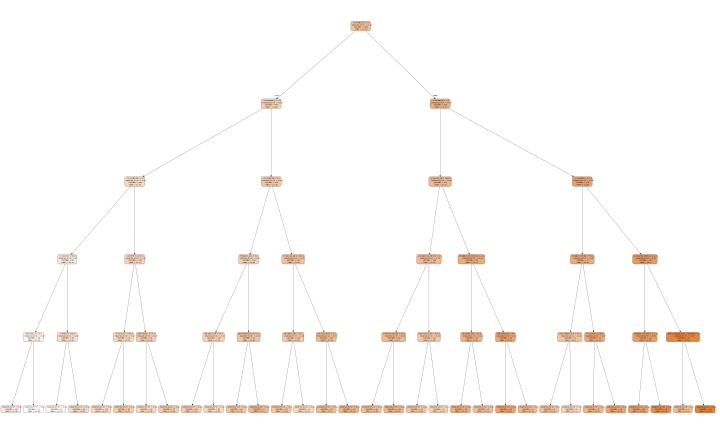

In [491]:
# create a regressor object

def draw_tree(t, df, size=10, ratio=0.6, precision=2, **kwargs):
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True, rounded=True,
                      special_characters=True, rotate=False, precision=precision, **kwargs)
    return graphviz.Source(re.sub('Tree {', f'Tree {{ size={size}; ratio={ratio}', s))
# fit the regressor with X and Y data
draw_tree(regressor, X_train, size=10)

In [492]:

#dot_data = export_graphviz(regressor, out_file ='tree.dot',
#			feature_names =features)
#graph = graphviz.Source(dot_data)
#graph.render("housing_dtree")  # housing_dtree is name of output file

#10. print out the correlations of the features against the response variable 'Log_SalePrice'

In [493]:
print(X_train.corrwith(y_train).sort_values(ascending=False))

OverallQual                      0.810019
GrLivArea_clip                   0.712801
GrLivArea_rnk                    0.696988
GarageCars                       0.689598
GrLivArea_minmax                 0.685134
GrLivArea                        0.685134
GrLivArea_norm                   0.685134
GarageArea_clip                  0.661421
GarageArea                       0.652080
GrLivArea_grp                    0.647091
GarageArea_rnk                   0.633352
GarageArea_grp                   0.629677
TotalBsmtSF_clip                 0.623564
YearBuilt                        0.618722
TotalBsmtSF_rnk                  0.594243
TotalBsmtSF                      0.593339
TotalBsmtSF_norm                 0.593339
TotalBsmtSF_minmax               0.593339
FullBath                         0.582710
1stFlrSF                         0.576680
YearRemodAdd                     0.551332
TotalBsmtSF_grp                  0.545237
TotRmsAbvGrd                     0.521248
Foundation_PConc                 0

In [494]:


# Compute the correlation matrix - looks like OverallQual is highly correlated with other strong field
mylist=['OverallQual','GarageCars','GrLivArea','GarageArea','TotalBsmtSF',
        'GrLivArea_clip','FullBath','YearBuilt','YearRemodAdd',

        'GarageFinish_Unf','BsmtQual_TA','Fireplaces_none','KitchenQual_TA','FullBath_1',
        'Years_untilsold_after_remodel','Age_when_sold','ExterQual_TA','Age_tens_clipped'
        ]
correlation_matrix = X_train[mylist].corr()
#correlation_matrix = X_train[features].corr()

# Print the correlation matrix
print(correlation_matrix)

                               OverallQual  GarageCars  GrLivArea  GarageArea  \
OverallQual                       1.000000    0.599301   0.583244    0.547868   
GarageCars                        0.599301    1.000000   0.464766    0.872552   
GrLivArea                         0.583244    0.464766   1.000000    0.478023   
GarageArea                        0.547868    0.872552   0.478023    1.000000   
TotalBsmtSF                       0.530420    0.440090   0.451142    0.491731   
GrLivArea_clip                    0.587938    0.488224   0.954045    0.472926   
FullBath                          0.537249    0.481600   0.614339    0.407394   
YearBuilt                         0.658577    0.569658   0.275425    0.482977   
YearRemodAdd                      0.536168    0.410927   0.282254    0.350236   
GarageFinish_Unf                 -0.413493   -0.218473  -0.234072   -0.192847   
BsmtQual_TA                      -0.487032   -0.454180  -0.267001   -0.351857   
Fireplaces_none             

#10. print out the correlations of the features against the response variable 'OverALLQual'

In [495]:
best_combofld=train['OverallQual']
print(X_train.corrwith(best_combofld).sort_values(ascending=False))

OverallQual                      1.000000
YearBuilt                        0.658577
GarageCars                       0.599301
GrLivArea_clip                   0.587938
GrLivArea_rnk                    0.583696
GrLivArea                        0.583244
GrLivArea_norm                   0.583244
GrLivArea_minmax                 0.583244
GrLivArea_grp                    0.558869
GarageArea_clip                  0.551876
Foundation_PConc                 0.549923
GarageArea                       0.547868
ExterQual_Gd                     0.545192
FullBath                         0.537249
YearRemodAdd                     0.536168
TotalBsmtSF                      0.530420
TotalBsmtSF_norm                 0.530420
TotalBsmtSF_minmax               0.530420
GarageArea_rnk                   0.529134
GarageArea_grp                   0.523852
TotalBsmtSF_clip                 0.519375
TotalBsmtSF_grp                  0.496914
HeatingQC_Ex                     0.477385
FullBath_2                       0

#9. Create cross-tabs of what looks like are the most predictive variables so for for Log_SalePrice

In [496]:
big_table=pd.DataFrame()
mylist=['OverallQual','GarageCars','GrLivArea','GarageArea','TotalBsmtSF',
        'BsmtQual_TA','KitchenQual_TA','ExterQual_TA']
for field in mylist:
    table = pd.pivot_table(train, values=["Log_SalePrice"], index=field,
                       aggfunc= ["count","sum", "mean"])
    print(table)

                    count           sum          mean
            Log_SalePrice Log_SalePrice Log_SalePrice
OverallQual                                          
1                       2     21.597609     10.798804
2                       1     11.002100     11.002100
3                      15    170.091110     11.339407
4                      83    959.321331     11.558088
5                     283   3335.436919     11.785996
6                     292   3494.651789     11.967986
7                     244   2980.762459     12.216240
8                     130   1624.761134     12.498163
9                      34    434.453187     12.778035
10                     11    141.920921     12.901902
                   count           sum          mean
           Log_SalePrice Log_SalePrice Log_SalePrice
GarageCars                                          
0                     58    665.304716     11.470771
1                    262   3074.800673     11.735880
2                    637   7699.9

<ipython-input-496-e6c38dbd9d00>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = pd.pivot_table(train, values=["Log_SalePrice"], index=field,
<ipython-input-496-e6c38dbd9d00>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = pd.pivot_table(train, values=["Log_SalePrice"], index=field,
<ipython-input-496-e6c38dbd9d00>:5: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  table = pd.pivot_table(train, values=["Log_SalePrice"], index=field,


Try different model structures

# Random Forest Regressor

In [497]:
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.linear_model import LinearRegression
rfc = RandomForestRegressor( random_state=0,n_estimators=200, min_samples_split=50,min_samples_leaf=50,max_depth=10)
rfc.fit(X_train, y_train)
#evaluate accuracy on train dataset
y_pred_train = rfc.predict(X_train)
exp_y_pred_train= np.exp(y_pred_train)

#evaluate model RMSE
mse = mean_squared_error(y_train, y_pred_train)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.17845718358339285


In [498]:
#score the model on the data
y_pred_valdtn = rfc.predict(X_valdtn)
exp_y_pred_valdtn= np.exp(y_pred_valdtn)
#tree.plot_tree(dtree, feature_names=features)
mse = mean_squared_error(y_valdtn, y_pred_valdtn)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.19180944802874425


this was originally here to try decision tree regressor again, but in much simpler state - like less levels

In [499]:
#try very simple model - univariate
#features = ["OverallQual"]

#features=['OverallQual','GarageCars','GrLivArea','GarageArea','TotalBsmtSF',
#        'BsmtQual_TA','KitchenQual_TA','ExterQual_TA'
#        ,'GrLivArea_cap','GrLivArea_grp','GrLivArea_rnk']

#X_train = train[features]
#y_train = train['Log_SalePrice']

# create a regressor object
regressor = DecisionTreeRegressor(random_state = 0,max_depth=10)

# fit the regressor with X and Y data
regressor.fit(X_train, y_train)

#score the model on the data
y_pred = regressor.predict(X_train)
exp_y_pred= np.exp(y_pred)
#tree.plot_tree(dtree, feature_names=features)

#evaluate model RMSE
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.04337835104383239


# Linear Regression in sklearn

TRY OUT LINEAR REGRESSION, TO SEE IF PERFORMS BETTER

In [500]:
#export the data to a csv, so I can run data through SAS on Demand
# I want to see what a best subset selection would look like
sas_export=X_train.copy()
sas_export["Log_SalePrice"] = y_train
# Convert boolean columns to integers (0 and 1)
for col in sas_export.select_dtypes(include='bool').columns:
    sas_export[col] = sas_export[col].astype(int)
try:
  sas_export.to_csv(("/kaggle/working/sas_export_for_modeling.csv"),index=False)
except:
  sas_export.to_csv(("gdrive/MyDrive/sas_export_for_modeling.csv"),index=False)

# now pick a type of linear regression to perform here

#'reduce collinearity prior' option to run below,  produces best result

In [510]:
#linear regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.model_selection import RepeatedKFold

#change this flag if want to do linear or lasso/l2 regularization
#linear_method='vanilla'
#linear_method='choose fields' # features out of stepwise in sas
linear_method='regularization' # this is the option to run to get the best result - i have reduced collinearity prior to running
#linear_method='forward'
#linear_method='best' #best was taking 40 minutes to run so I cancelled the run
#linear_method='parameter search' # I got this code to work - but should really optimize lasso or ridge#
#linear_method='reduce collinearity prior'
#linear_method='xgboost gain fields'

if linear_method=='regularization':
  #do this in elasticNet, to have regularization because I know that many of my features are highly correlated/redundant
  from sklearn.linear_model import ElasticNet
  from sklearn.model_selection import GridSearchCV
#  linmodel = ElasticNet(alpha=0.1,l1_ratio=1)  # l1_ratio=0.5->l1_ratio controls the mix of L1 and L2; l1_ration=1 means l1 regularizatin entirely

#  selected_features=X_train.columns
#tried to reduce features by collinearity
  selected_features =[
      '1stFlrSF','2ndFlrSF','3SsnPorch','Age_at_remodel','Age_eq0_new_flag','Age_tens_clipped','BedroomAbvGr_3','BedroomAbvGr_4',
      'BldgType_1Fam','BldgType_2fmCon','BldgType_Duplex','BldgType_Twnhs','BsmtCond_Fa','BsmtCond_Gd','BsmtCond_nan','BsmtCond_TA',
      'BsmtExposure_Av','BsmtExposure_Gd','BsmtExposure_nan','BsmtExposure_No','BsmtFinSF1','BsmtFinSF2_clip','BsmtFinType1_ALQ',
      'BsmtFinType1_BLQ','BsmtFinType1_GLQ','BsmtFinType1_Other','BsmtFinType1_Unf','BsmtFinType2_BLQ','BsmtFinType2_GLQ','BsmtFinType2_LwQ',
      'BsmtFinType2_Rec','BsmtFinType2_Unf','BsmtFullBath','BsmtHalfBath','BsmtQual_Ex','BsmtQual_Fa','BsmtQual_Gd','BsmtQual_TA','BsmtUnfSF',
      'CentralAir_Y','Condition1_Artery','Condition1_Feedr','Condition1_Norm','Condition2_Norm','Electrical_FuseA','Electrical_SBrkr',
      'EnclosedPorch_rnk','ExterCond_Ex','ExterCond_Gd','ExterCond_TA','Exterior1st_HdBoard','Exterior1st_VinylSd','Exterior2nd_HdBoard',
      'Exterior2nd_VinylSd','ExterQual_Ex','ExterQual_Gd','ExterQual_TA','Fireplaces_gt0','Foundation_CBlock','Foundation_PConc','FullBath',
      'Functional_Typ','GarageArea_clip','GarageCars','GarageCond_TA','GarageFinish_Fin','GarageFinish_RFn','GarageFinish_Unf','GarageQual_TA',
      'GarageType_Attchd','GarageType_BuiltIn','GarageType_Detchd','GarageType_Other','GarageYrBlt','GrLivArea_clip','HalfBath','Heating_GasA',
      'HeatingQC_Ex','HeatingQC_Gd','HeatingQC_TA','HouseStyle_1.5Fin','HouseStyle_1Story','HouseStyle_2Story','KitchenAbvGr','KitchenQual_Ex',
      'KitchenQual_Gd','KitchenQual_TA','LandContour_Lvl','LandSlope_Gtl','LandSlope_Sev','LotArea_rnk','LotConfig_Corner','LotConfig_CulDSac',
      'LotConfig_Inside','LotFrontage_clip','LotShape_IR1','LotShape_Reg','LowQualFinSF_rnk','MasVnrArea','MiscVal_rnk','MoSold_10','MoSold_11',
      'MoSold_12','MoSold_2','MoSold_3','MoSold_4','MoSold_5','MoSold_6','MoSold_7','MoSold_8','MoSold_9','MSSubClass_120','MSSubClass_160',
      'MSSubClass_20','MSSubClass_30','MSSubClass_50','MSSubClass_60','MSSubClass_70','MSSubClass_80','MSSubClass_90','MSZoning_FV','MSZoning_RL',
      'MSZoning_RM','Neighborhood_Edwards','Neighborhood_NAmes','OpenPorchSF_rnk','OverallCond','OverallQual','PavedDrive_N','PavedDrive_Y','PoolArea',
      'Remodeled_flag','RoofMatl_CompShg','RoofStyle_Gable','RoofStyle_Hip','SaleCondition_Alloca','SaleCondition_Normal','SaleCondition_Other',
      'SaleCondition_Partial','SaleType_COD','SaleType_New','SaleType_WD','ScreenPorch_grp','Street_Grvl','TotalBsmtSF_clip','TotRmsAbvGrd',
      'Utilities_AllPub','WoodDeckSF_rnk','YearBuilt','YearBuilt_pre1950_flag','YearRemodAdd','Years_untilsold_after_remodel','YrSold_2007',
      'YrSold_2008','YrSold_2009','YrSold_2010']
#  linmodel.fit(selected_X_train, y_train)
  selected_X_train = X_train[selected_features]
  model = ElasticNet()

  # Hyperparameter grid to search
  param_grid = {
     'fit_intercept': [True],
     'max_iter': range(350, 450, 50),
     'alpha': [0.001,0.005,0.01,0.02,0.05,0.1,0.2,0.5,1,2,5,10,100],
     'l1_ratio': [0,0.01,0.02,0.05,0.1,0.2,0.5,0.9,0.99,1],
     'tol': [0.01,0.1]
  }

  # Create a GridSearchCV
  grid_search = GridSearchCV(estimator=model,
                          param_grid=param_grid,
                          cv=5,
                          scoring='neg_root_mean_squared_error')

  # Fit the grid search to the training data
  grid_search.fit(selected_X_train, y_train)

  # Get the best parameters
  best_params = grid_search.best_params_
  print("Best parameters:", best_params)

  # Create a new model with the best parameters
  linmodel = ElasticNet(**best_params)
  linmodel.fit(selected_X_train, y_train)


elif linear_method=='forward' : #forward selection
  from sklearn.feature_selection import SequentialFeatureSelector

  # Create a linear regression model
  linmodel = LinearRegression()

    # Create the forward feature selector
  sfs = SequentialFeatureSelector(linmodel, n_features_to_select=30, direction='forward')

  # Fit the selector on the data
  sfs.fit(X_train, y_train)

  # Get the selected features
  selected_features = X_train.columns[sfs.get_support()]

  print("Selected features:", selected_features)

 # Fit the model to the training data
  selected_X_train = X_train[selected_features]
  linmodel.fit(selected_X_train, y_train)
elif linear_method=='best' : #best selection

  lr = LinearRegression()

  efs = EFS(lr,
          min_features=10,
          max_features=12,
          scoring='neg_mean_squared_error',
          cv=10)

  efs.fit(X_train, y_train)

  selected_features=X_train.columns

  print('Best MSE score: %.2f' % efs.best_score_ * (-1))
  print('Best subset:', efs.best_idx_)
  print('Best subset (corresponding names):', efs.best_feature_names_)


elif linear_method=='parameter search': #search for best settings for hyperparameters

  # Create a LinearRegression model
  linmodel = LinearRegression()

  param_space = {'copy_X': [True,False],
               'fit_intercept': [True,False],
               'n_jobs': [1,5,10,15,None],
               'positive': [True,False]}

  # Fit the model to the training data
  selected_X_train = X_train
  selected_features=X_train.columns
# Valid parameters are: ['copy_X', 'fit_intercept', 'n_jobs', 'positive'].
  random_search = RandomizedSearchCV(linmodel, param_space, n_iter=100, scoring='neg_mean_squared_error') #cv=5 was taken out, because only good for logistic
  random_search.fit(selected_X_train, y_train)

#  # Parameter which gives the best results
  print(f"Best Hyperparameters: {random_search.best_params_}")

# Accuracy of the model after using best parameters
  print(f"Best Score: {random_search.best_score_}")

  params=random_search.best_params_
  linmodel.set_params(**params)
  linmodel.fit(selected_X_train, y_train)

elif linear_method=='choose fields': #stepwise in sas- this seems to get best result so far
  # Create a LinearRegression model
  linmodel = LinearRegression()

  # Fit the model to the training data
  # I stuck with unstandardized continuous variables, because model with transformed versions performed worse, and transformed features didn't look like had linear relationship
  selected_features =['OverallQual','GrLivArea_clip','TotalBsmtSF_rnk','Age_when_sold', 'OverallCond',
    'LotArea_clip','BsmtUnfSF_clip','GarageCars','KitchenAbvGr','Foundation_PConc','Fireplaces',
    'BsmtQual_Ex','Functional_nan','Condition1_Norm','MSZoning_FV','BsmtFullBath','MSZoning_RL']
 # selected_features =['OverallQual','GrLivArea_minmax','TotalBsmtSF_minmax','Age_when_sold', 'OverallCond',
 #   'LotArea_minmax','BsmtUnfSF_minmax','GarageCars','KitchenAbvGr','Foundation_PConc','Fireplaces',
 #   'BsmtQual_Ex','Functional_nan','Condition1_Norm','MSZoning_FV','BsmtFullBath','MSZoning_RL']
 # selected_features =['OverallQual','GrLivArea_norm','TotalBsmtSF_norm','Age_when_sold', 'OverallCond',
 #   'LotArea_norm','BsmtUnfSF_norm','GarageCars','KitchenAbvGr','Foundation_PConc','Fireplaces',
 #   'BsmtQual_Ex','Functional_nan','Condition1_Norm','MSZoning_FV','BsmtFullBath','MSZoning_RL']

  selected_X_train = X_train[selected_features]
  linmodel.fit(selected_X_train, y_train)


elif linear_method=='reduce collinearity prior': #picked variables in excel from correlation to log_saleprice
  # Create a LinearRegression model
  linmodel = LinearRegression()

  # Fit the model to the training data
  # I stuck with unstandardized continuous variables, because model with transformed versions performed worse, and transformed features didn't look like had linear relationship
  selected_features =[
      '1stFlrSF','2ndFlrSF','3SsnPorch','Age_at_remodel','Age_eq0_new_flag','Age_tens_clipped','BedroomAbvGr_3','BedroomAbvGr_4',
      'BldgType_1Fam','BldgType_2fmCon','BldgType_Duplex','BldgType_Twnhs','BsmtCond_Fa','BsmtCond_Gd','BsmtCond_nan','BsmtCond_TA',
      'BsmtExposure_Av','BsmtExposure_Gd','BsmtExposure_nan','BsmtExposure_No','BsmtFinSF1','BsmtFinSF2_clip','BsmtFinType1_ALQ',
      'BsmtFinType1_BLQ','BsmtFinType1_GLQ','BsmtFinType1_Other','BsmtFinType1_Unf','BsmtFinType2_BLQ','BsmtFinType2_GLQ','BsmtFinType2_LwQ',
      'BsmtFinType2_Rec','BsmtFinType2_Unf','BsmtFullBath','BsmtHalfBath','BsmtQual_Ex','BsmtQual_Fa','BsmtQual_Gd','BsmtQual_TA','BsmtUnfSF',
      'CentralAir_Y','Condition1_Artery','Condition1_Feedr','Condition1_Norm','Condition2_Norm','Electrical_FuseA','Electrical_SBrkr',
      'EnclosedPorch_rnk','ExterCond_Ex','ExterCond_Gd','ExterCond_TA','Exterior1st_HdBoard','Exterior1st_VinylSd','Exterior2nd_HdBoard',
      'Exterior2nd_VinylSd','ExterQual_Ex','ExterQual_Gd','ExterQual_TA','Fireplaces_gt0','Foundation_CBlock','Foundation_PConc','FullBath',
      'Functional_Typ','GarageArea_clip','GarageCars','GarageCond_TA','GarageFinish_Fin','GarageFinish_RFn','GarageFinish_Unf','GarageQual_TA',
      'GarageType_Attchd','GarageType_BuiltIn','GarageType_Detchd','GarageType_Other','GarageYrBlt','GrLivArea_clip','HalfBath','Heating_GasA',
      'HeatingQC_Ex','HeatingQC_Gd','HeatingQC_TA','HouseStyle_1.5Fin','HouseStyle_1Story','HouseStyle_2Story','KitchenAbvGr','KitchenQual_Ex',
      'KitchenQual_Gd','KitchenQual_TA','LandContour_Lvl','LandSlope_Gtl','LandSlope_Sev','LotArea_rnk','LotConfig_Corner','LotConfig_CulDSac',
      'LotConfig_Inside','LotFrontage_clip','LotShape_IR1','LotShape_Reg','LowQualFinSF_rnk','MasVnrArea','MiscVal_rnk','MoSold_10','MoSold_11',
      'MoSold_12','MoSold_2','MoSold_3','MoSold_4','MoSold_5','MoSold_6','MoSold_7','MoSold_8','MoSold_9','MSSubClass_120','MSSubClass_160',
      'MSSubClass_20','MSSubClass_30','MSSubClass_50','MSSubClass_60','MSSubClass_70','MSSubClass_80','MSSubClass_90','MSZoning_FV','MSZoning_RL',
      'MSZoning_RM','Neighborhood_Edwards','Neighborhood_NAmes','OpenPorchSF_rnk','OverallCond','OverallQual','PavedDrive_N','PavedDrive_Y','PoolArea',
      'Remodeled_flag','RoofMatl_CompShg','RoofStyle_Gable','RoofStyle_Hip','SaleCondition_Alloca','SaleCondition_Normal','SaleCondition_Other',
      'SaleCondition_Partial','SaleType_COD','SaleType_New','SaleType_WD','ScreenPorch_grp','Street_Grvl','TotalBsmtSF_clip','TotRmsAbvGrd',
      'Utilities_AllPub','WoodDeckSF_rnk','YearBuilt','YearBuilt_pre1950_flag','YearRemodAdd','Years_untilsold_after_remodel','YrSold_2007',
      'YrSold_2008','YrSold_2009','YrSold_2010']




  selected_X_train = X_train[selected_features]
  linmodel.fit(selected_X_train, y_train)

# these aren't the best choices for linear regression - but what xgboost outputs as the most gain in the branches
elif linear_method=='xgboost gain fields': #picked variables from xgboost gain fields in next section
  # Create a LinearRegression model
  linmodel = LinearRegression()

  # Fit the model to the training data
  # I stuck with unstandardized continuous variables, because model with transformed versions performed worse, and transformed features didn't look like had linear relationship
  selected_features =['OverallQual','GrLivArea_clip','GarageCars','TotalBsmtSF_clip','BsmtQual_Ex',
    "CentralAir_N","GarageFinish_Unf","FullBath","GrLivArea","GarageType_Detchd" ]




  selected_X_train = X_train[selected_features]
  linmodel.fit(selected_X_train, y_train)


else: #vanilla - this seemed to get the best result, but reducing collinarity prior produces better result
  # Create a LinearRegression model
  linmodel = LinearRegression()

  # Fit the model to the training data
  selected_X_train = X_train
  selected_features=X_train.columns
  linmodel.fit(selected_X_train, y_train)

# Print the coefficients and intercept
print("Coefficients:", linmodel.coef_)
print("Intercept:", linmodel.intercept_)
for linparam in list(zip(linmodel.coef_, selected_X_train.columns)):
  print(linparam)

# Visualize the results
#plt.scatter(X_train[:, 0], y_train, color='blue')
#plt.plot(X_train[:, 0], y_pred_lin, color='red')
#plt.title('Linear Regression Example')
#plt.xlabel('Feature 1')
#plt.ylabel('Target')
#plt.show()


#score the model on the data
y_pred_lin = linmodel.predict(selected_X_train)
exp_y_pred_lin= np.exp(y_pred_lin)
#tree.plot_tree(dtree, feature_names=features)

#evaluate model RMSE
mse_lin = mean_squared_error(y_train, y_pred_lin)
rmse_lin = np.sqrt(mse_lin)
print('Linear regression method:',linear_method)
print("RMSE:", rmse_lin)

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.846e+00, tolerance: 1.325e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_model.Ridge/RidgeCV instead.
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.190e+00, tolerance: 1.396e+00 Linear regression models with null weight for the l1 regularization term are more efficiently fitted using one of the solvers implemented in sklearn.linear_mode

Best parameters: {'alpha': 0.02, 'fit_intercept': True, 'l1_ratio': 0.01, 'max_iter': 350, 'tol': 0.01}
Coefficients: [ 2.95419052e-05  4.76318190e-05  1.70760408e-04 -2.72347853e-03
 -0.00000000e+00  9.51617690e-04 -1.31317704e-02  7.43351295e-03
  2.49472629e-02  0.00000000e+00 -1.04497038e-02 -1.76071095e-02
 -2.62213641e-02  4.61986115e-04  0.00000000e+00  1.00963439e-02
 -7.34128344e-03  3.94725366e-02  0.00000000e+00 -1.30165764e-02
 -1.94546138e-04 -3.85291380e-04  2.39833111e-03  0.00000000e+00
  9.02188077e-03 -9.26423020e-03 -1.26758045e-02 -7.79789446e-03
 -7.24364577e-03  0.00000000e+00  6.65753646e-04 -0.00000000e+00
  3.01728982e-02  1.57852334e-03  2.90332043e-02  0.00000000e+00
 -1.09872721e-02 -2.19081005e-02 -2.50137355e-04  4.33252826e-02
 -1.26800476e-02  0.00000000e+00  4.20273956e-02  2.58933044e-02
  7.05220518e-03 -4.76697622e-03  4.06499347e-03  0.00000000e+00
 -1.08237363e-02  9.56005351e-03 -5.72147236e-03 -2.96041781e-04
 -0.00000000e+00 -9.06428524e-03  1.6

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.591e+00, tolerance: 1.694e+00
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.591e+00, tolerance: 1.694e+00
  model = cd_fast.enet_coordinate_descent(


In [512]:
#score the model on the data
#if selected_features==[]:
#  selected_X_valdtn = X_valdtn
#else:
selected_X_valdtn = X_valdtn[selected_features]


#selected_X_valdtn=X_valdtn
y_pred_valdtn = linmodel.predict(selected_X_valdtn)
exp_y_pred_valdtn= np.exp(y_pred_valdtn)
#tree.plot_tree(dtree, feature_names=features)
mse = mean_squared_error(y_valdtn, y_pred_valdtn)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

RMSE: 0.13071274459889612




```
```

# XGBOOST model


TRY OUT XGBOOST FORM OF MODEL, ON BOTH TRAIN AND VALIDATION

[0]	train-rmse:0.29644	valid-rmse:0.32192
[10]	train-rmse:0.05818	valid-rmse:0.14644
[20]	train-rmse:0.03957	valid-rmse:0.14316
[30]	train-rmse:0.02972	valid-rmse:0.14362
[40]	train-rmse:0.02259	valid-rmse:0.14325
[49]	train-rmse:0.01764	valid-rmse:0.14304


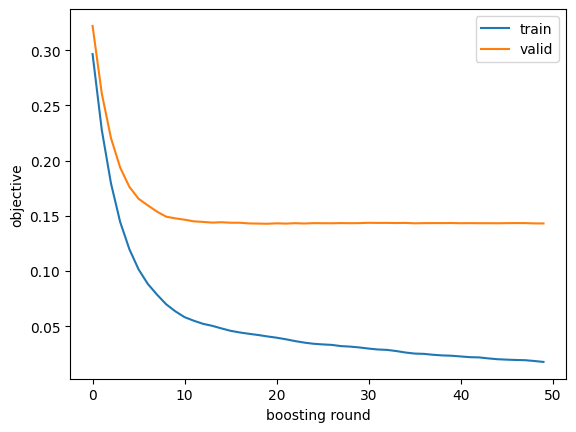

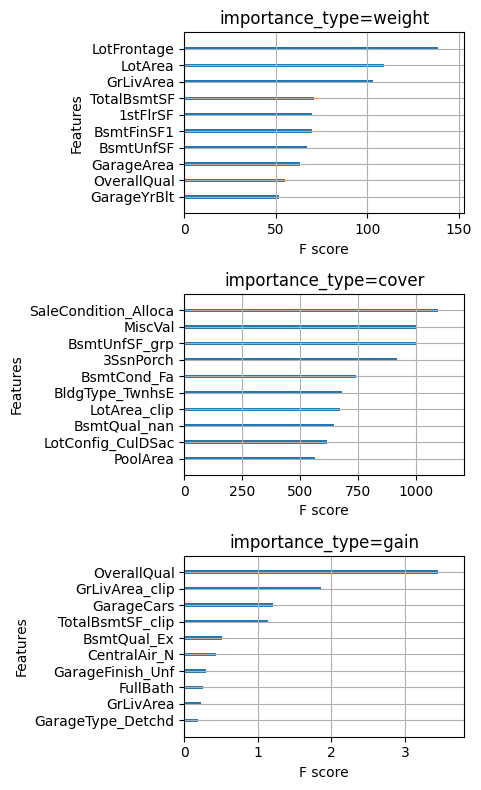

In [513]:

# check xgboost version
import xgboost as xgb
#print(xgboost.__version__)


dtrain = xgb.DMatrix(data=X_train, label=y_train,
                     enable_categorical=True)
dvalid = xgb.DMatrix(data=X_valdtn, label=y_valdtn,
                     enable_categorical=True)
# default values for important parameters
params = {
    'tree_method': 'approx',
    'learning_rate': 0.3, #code lr was 0.3 - i tried 0.01 and that was way worse
    'max_depth': 6, # tried 10, but got worse
    'min_child_weight': 1,
    'subsample': 1,
    'colsample_bynode': 1,
    'objective': 'reg:squarederror',
}

num_boost_round = 50


evals_result = {}
model = xgb.train(params=params, dtrain=dtrain, num_boost_round=num_boost_round,
                  evals=[(dtrain, 'train'), (dvalid, 'valid')],
                  verbose_eval=10,
                  evals_result=evals_result)
pd.DataFrame({
    'train': evals_result['train']['rmse'],
    'valid': evals_result['valid']['rmse']
}).plot(); plt.xlabel('boosting round'); plt.ylabel('objective');

from sklearn.metrics import mean_squared_error

from sklearn.metrics import root_mean_squared_error
# squared=False returns RMSE
root_mean_squared_error(y_true=dvalid.get_label(),
                   y_pred=model.predict(dvalid))

#feature importance
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(5, 8))
xgb.plot_importance(model, importance_type='weight', title='importance_type=weight',
                    max_num_features=10, show_values=False, ax=ax1, )
xgb.plot_importance(model, importance_type='cover', title='importance_type=cover',
                    max_num_features=10, show_values=False, ax=ax2)
xgb.plot_importance(model, importance_type='gain', title='importance_type=gain',
                    max_num_features=10, show_values=False, ax=ax3)
plt.tight_layout()

“The Gain implies the relative contribution of the corresponding feature to the model calculated by taking each feature’s contribution for each tree in the model. A higher value of this metric when compared to another feature implies it is more important for generating a prediction.

The Coverage metric means the relative number of observations related to this feature. For example, if you have 100 observations, 4 features and 3 trees, and suppose feature1 is used to decide the leaf node for 10, 5, and 2 observations in tree1, tree2 and tree3 respectively; then the metric will count cover for this feature as 10+5+2 = 17 observations. This will be calculated for all the 4 features and the cover will be 17 expressed as a percentage for all features’ cover metrics.

The Frequency (R)/Weight (python) is the percentage representing the relative number of times a particular feature occurs in the trees of the model. In the above example, if feature1 occurred in 2 splits, 1 split and 3 splits in each of tree1, tree2 and tree3; then the weight for feature1 will be 2+1+3 = 6. The frequency for feature1 is calculated as its percentage weight over weights of all features.

The Gain is the most relevant attribute to interpret the relative importance of each feature.

‘Gain’ is the improvement in accuracy brought by a feature to the branches it is on. The idea is that before adding a new split on a feature X to the branch there was some wrongly classified elements, after adding the split on this feature, there are two new branches, and each of these branch is more accurate (one branch saying if your observation is on this branch then it should be classified as 1, and the other branch saying the exact opposite).

‘Coverage’ measures the relative quantity of observations concerned by a feature.”[3]


#11. read in the test dataset for the kaggle competition (without the flags for survival)

In [514]:
try:
  house_df_test=pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")
except:
  house_df_test=pd.read_csv("gdrive/MyDrive/home-data-for-ml-course/test.csv")

In [515]:
test=pd.DataFrame()

test_df=house_df_test

#MSSubCLass - 180, 190,40, 45, 75, 85
#test_df["MSSubCLass"] = test_df["MSSubCLass"].replace([40,45,75,85,180,190], 'Other')
test_df["MSSubClass"] = pd.Categorical(test_df['MSSubClass'], categories=[20,30,50,60,70,80,90,120,150,160])
#utlities_nan
#Condition2_Feedr

test_df['Age_when_sold']=test_df['YrSold'] - test_df['YearBuilt']

test_df['Age_eq0_new_flag']=test_df['Age_when_sold']<1
test_df['Age_tens_clipped']=(test_df['Age_when_sold']//10*10).clip(upper=60)
test_df['Age_gt60_flag']=test_df['Age_when_sold']>600

test_df['Years_untilsold_after_remodel'] = test_df['YrSold'] - test_df['YearRemodAdd']
test_df['Age_at_remodel'] = test_df['YearRemodAdd'] - test_df['YearBuilt']
test_df['Remodeled_flag'] = test_df['Age_at_remodel']>1

#YRSold - make dummies
test_df['YrSold'] = pd.Categorical(test_df['YrSold'])

test_df["MSZoning"] = test_df["MSZoning"].replace(['A', 'C (all)','I','RH','RP'], 'Other')
print(val_df['MSZoning'].unique())
test_df["RoofStyle"] = test_df["RoofStyle"].replace(['Flat','Gambrel','Mansard','Shed'], 'Other')
test_df['Foundation'] = test_df["Foundation"].replace(['BrkTil','Slab','Stone','Wood'], 'Other')
test_df['BsmtFinType1'] = test_df["BsmtFinType1"].replace(['Rec','LwQ'], 'Other')
test_df['GarageType'] = test_df["GarageType"].replace(['2Types','Basment','Carport'], 'Other')
test_df['SaleType'] = test_df["SaleType"].replace(['CWD','VWD','Con','ConLw','ConLI','ConLD','Oth'],'Other')
test_df['SaleCondition'] = test_df["SaleCondition"].replace(['AdjLand','Family','Alloc'],'Other')



test_df['LotShape'] = pd.Categorical(test_df['LotShape'], categories=['Reg', 'IR1','Ir2'])
test_df['LandContour'] = pd.Categorical(test_df['LandContour'], categories=['Lvl'])
test_df['LotConfig'] = pd.Categorical(test_df['LotConfig'], categories=['Inside','Corner','CulDSac'])
test_df['Neighborhood'] = pd.Categorical(test_df['Neighborhood'], categories=['NAmes','OldTOwn','Edwards'])
test_df['Condition1'] = pd.Categorical(test_df['Condition1'], categories=['Norm','Feedr','Artery'])
test_df['Condition2'] = pd.Categorical(test_df['Condition2'], categories=['Norm'])
test_df['HouseStyle'] = pd.Categorical(test_df['HouseStyle'], categories=['1Story','2Story','1.5Fin'])
test_df['RoofMatl'] = pd.Categorical(test_df['RoofMatl'], categories=['CompShg'])
test_df['Exterior1st'] = pd.Categorical(test_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
test_df['Exterior2nd'] = pd.Categorical(test_df['Exterior2nd'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
test_df['BedroomAbvGr'] = pd.Categorical(test_df['BedroomAbvGr'], categories=[1,2,3,4])
test_df['KitchenAbvGr'] = pd.Categorical(test_df['KitchenAbvGr'], categories=[1,2])
test_df['Functional'] = pd.Categorical(test_df['Functional'], categories=['Typ'])
test_df['Fireplaces'] = pd.Categorical(test_df['Fireplaces'], categories=[0,1,2])
test_df['GarageCars'] = pd.Categorical(test_df['GarageCars'], categories=[0,1,2,3])



test_df['Exterior1st'] = pd.Categorical(test_df['Exterior1st'], categories=['VinylSd','HdBoard','WD Sdng','MetalSD'])
test_df['Heating'] = pd.Categorical(test_df['Heating'], categories=['GasA'])
test_df['Electrical'] = pd.Categorical(test_df['Electrical'], categories=['SBrkr','FuseA'])
test_df['ExterCond'] = pd.Categorical(test_df['ExterCond'], categories=['TA','Gd','Ex'])
test_df['GarageCond'] = pd.Categorical(test_df['GarageCond'], categories=['TA'])
test_df['GarageQual'] = pd.Categorical(test_df['GarageQual'], categories=['TA'])
test_df['HeatingQC'] = pd.Categorical(test_df['HeatingQC'], categories=['TA','Gd','Ex'])
test_df['Utilities'] = pd.Categorical(test_df['Utilities'], categories=['AllPub'])



for field in catdict:
    if catdict[field]=="cat" and (field not in drop_majnulls):
#        if field in missing_dummies:
#             dummies_class = pd.get_dummies(trn_df[field].astype('str'),prefix=field, dummy_na=True) #leave all  classes for now, though one is redundant
#        else:
        dummies_class = pd.get_dummies(house_df_test[field].astype('str'),prefix=field) #don't make dummy class if no nulls
        test = pd.concat([test, dummies_class], axis=1)
    elif catdict[field] in ["numeric","rank","date","unique"] and (field not in drop_majnulls):
         if field[0]=='_':
             field=field[1:]
             print(field)
         fields_asis=house_df_test[field]
         test = pd.concat([test, fields_asis], axis=1)

test['Age_when_sold']=test_df['Age_when_sold']

test['Age_eq0_new_flag']=test_df['Age_eq0_new_flag']
test['Age_tens_clipped']=test_df['Age_tens_clipped']
test['Age_gt60_flag']=test_df['Age_gt60_flag']

test['Years_untilsold_after_remodel']=test_df['Years_untilsold_after_remodel']
test['Age_at_remodel']=test_df['Age_at_remodel']
test['Remodeled_flag']=test_df['Remodeled_flag']

#  'GarageArea_clip'
#  'TotalBsmtSF_rnk'
#  'TotalBsmtSF_grp'
#  'TotalBsmtSF_clip'
#  'BsmtUnfSF_rnk'
#  'BsmtUnfSF_grp'
#  'BsmtUnfSF_clip'
#  'BsmtFinSF2_rnk'
#  'BsmtFinSF2_grp'
#  'GarageArea_grp'
#  'BsmtFinSF2_clip'
#  'GarageArea_rnk'
fillna_minornulls_test=fillna_minornulls
fillna_minornulls.extend(['GarageArea','BsmtFinSF1','BsmtFullBath','BsmtHalfBath',
                          'BsmtFinSF2','BsmtUnfSF','TotalBsmtSF'])
for fld in fillna_minornulls:
    test[fld] = test[fld].fillna(modes[fld])
for fld in rmndr_fillna:
    test[fld] = test[fld].fillna(modes[fld])


for fld in regroup_num_fields:
  #fix the onews that start with '-'
  if fld[0]=='_':
             fld=fld[1:]
  # Calculate the 95th percentile value
  #MKO REVISIT HOW TO SAVE...
  upper_limit = train[fld].quantile(0.95)
  # Clip the values at the 95th percentile
  test[fld+'_clip'] = test[fld].clip(upper=upper_limit)

  #MKO REVISIT HOW TO SAVE...
  mymax=train[fld].max()
  tenths_of_fld=mymax/10
  tenth_ranges=test[fld]//tenths_of_fld
  test[fld+'_grp']=tenth_ranges*tenths_of_fld

  #MKO REVISIT HOW TO SAVE...
  # Rank the values
  test[fld+'_rnk'] = test[fld].rank(method='average')
  # Normalize the ranks to the range 1-10
  test[fld+'_rnk'] = ((test[fld+'_rnk'] - 1) / (test[fld+'_rnk'].max() - 1) * 9 + 1)//1*1 # mko added last two to get integer ranks

test['YearBuilt_pre1950_flag']=test_df['YearBuilt']<1950
test['YearBuilt']=(test['YearBuilt']//10*10).clip(lower=1950)
test['YearRemodAdd'] = test['YearRemodAdd']//10*10
test['2ndFlrSF_gt0']= test['2ndFlrSF']>=0
test['FullBath_1']=test['FullBath']==1
test['FullBath_2']=test['FullBath']==2
test['HalfBath_0']=test['HalfBath']==0
test['HalfBath_1']=test['HalfBath']==1
test['BedroomAbvGr_4']=test['BedroomAbvGr']==4
test['BedroomAbvGr_3']=test['BedroomAbvGr']==3
test['BedroomAbvGr_2']=test['BedroomAbvGr']==2

test['Fireplaces_none']=test['Fireplaces']==0
test['Fireplaces_one']=test['Fireplaces']==1
test['Fireplaces_gt0']=test['Fireplaces']!=0

test['WoodDeckSF_gt0']=test['WoodDeckSF']>=0
test['OpenPorchSF_gt0']=test['OpenPorchSF']>=0
test['EnclosedPorch_gt0']=test['EnclosedPorch']>=0
#i dropped pool qc because mostly empty field
test['PoolArea_none'] = test['PoolArea']==0

# minmax scale just the 4 continuous features that make their way into sas stepwise model - to test impact
# Only transform on the test set

minmax_scaled_data_test = scaler.transform(test[rawdata_features])
minmax_df_test = pd.DataFrame(minmax_scaled_data_test,
                                columns =['GrLivArea_minmax', 'LotArea_minmax','BsmtUnfSF_minmax','TotalBsmtSF_minmax'])
print('**',minmax_df_test.head(5),'**')

minmax_df_test.index = test.index
print('V=',test.shape, 'MM=', minmax_df_test.shape)
test = pd.concat([test, minmax_df_test], axis=1)

norm_scaled_data_test = sc.transform(test[continuous_vars_to_rescale])
norm_df_test = pd.DataFrame(norm_scaled_data_test ,
#                              columns =continuous_vars_to_rescale)
                              columns =['GrLivArea_norm', 'LotArea_norm','BsmtUnfSF_norm','TotalBsmtSF_norm'])
print('**',norm_df_test.head(5),'**')
# Apply df1's index to df2
norm_df_test.index = test.index
print('V=',test.shape, 'Norm=', norm_df_test.shape)
test = pd.concat([test, norm_df_test], axis=1)
#test[continuous_vars_to_rescale]=norm_df_test[continuous_vars_to_rescale]


if 'Utilities_nan' in test.columns:
  test.drop("Utilities_nan", axis=1,inplace=True)
#if 'Utilities_nan' not in test.columns:
#  test['Utilities_nan'] = False

#SalePrice not on test file
#test["Log_SalePrice"]=np.log(housefile_test["SalePrice"])
#print(np.log(housefile_test["SalePrice"]),housefile_test["SalePrice"])
#add in Id field, so it is there for submission
#test = pd.concat([test, house_df_test["Id"]], axis=1)

['RL' 'RM' 'Other' 'FV']
1stFlrSF
2ndFlrSF
3SsnPorch
**    GrLivArea_minmax  LotArea_minmax  BsmtUnfSF_minmax  TotalBsmtSF_minmax
0          0.105878        0.048246          0.115582            0.144354
1          0.187453        0.060609          0.173801            0.217512
2          0.243971        0.058566          0.058647            0.151882
3          0.239261        0.040562          0.138699            0.151555
4          0.178222        0.017318          0.435360            0.209493 **
V= (1459, 258) MM= (1459, 4)
**    GrLivArea_norm  LotArea_norm  BsmtUnfSF_norm  TotalBsmtSF_norm
0       -1.205437      0.079104       -0.671958         -0.402914
1       -0.383738      0.318236       -0.366108          0.604576
2        0.185568      0.278727       -0.971062         -0.299235
3        0.138126     -0.069529       -0.550518         -0.303742
4       -0.476725     -0.519134        1.007968          0.494136 **
V= (1459, 262) Norm= (1459, 4)


#12. for now...until figure out how to handle missings


In [516]:
print(test.describe())
print(test.info())
#print(test.isnull)
#test.dropna(inplace=True) # consider how to handle this for final submission - dropping records probably not ok

                Id  LotFrontage       LotArea  OverallQual  OverallCond  \
count  1459.000000  1459.000000   1459.000000  1459.000000  1459.000000   
mean   2190.000000    67.245374   9819.161069     6.078821     5.553804   
std     421.321334    20.795268   4955.517327     1.436812     1.113740   
min    1461.000000    21.000000   1470.000000     1.000000     1.000000   
25%    1825.500000    60.000000   7391.000000     5.000000     5.000000   
50%    2190.000000    63.000000   9399.000000     6.000000     5.000000   
75%    2554.500000    78.000000  11517.500000     7.000000     6.000000   
max    2919.000000   200.000000  56600.000000    10.000000     9.000000   

         YearBuilt  YearRemodAdd   MasVnrArea   BsmtFinSF1   BsmtFinSF2  \
count  1459.000000   1459.000000  1459.000000  1459.000000  1459.000000   
mean   1972.892392   1979.458533    99.673749   438.902673    52.583276   
std      20.796784     20.127717   177.001792   455.257119   176.698671   
min    1950.000000   195

In [517]:
missing_test = test.isnull().sum()
missing_test = missing_test[missing_test > 0]
missing_test.sort_values(inplace=True)
print(missing_test)
#missing_test.plot.bar()

Series([], dtype: int64)


In [518]:
#drop the columns that were all set to just 1 distinct value in test dataset
for col in colnames_to_drop:
  test.drop(col, axis=1,inplace=True)

#13. Code to submit output file to Kaggle. This isn't working correctly right now

In [519]:
### this is to create output file to submit to Kaggle
#dtree had best outcome on the test file, according to Kaggle


#if selected_features==[]:
#  X_test = test[features]
#else:
X_test = test[selected_features]

dtest = xgb.DMatrix(data=X_test,
                     enable_categorical=True)

#y_test_pred_dt = regressor.predict(X_test) #regressor is the DecisionTreeRegression specified earlier
#y_test_pred_dt = model.predict(dtest) #regressor is the xgboost model - let's see the result of this

#let's see how linear model does when i submit to kaggle
y_test_pred_dt = linmodel.predict(X_test)

#convert out the log
exp_y_pred_test= np.exp(y_test_pred_dt)

srs_y_test_pred=pd.Series(exp_y_pred_test)
house_test_output_dt=test.copy()
house_test_output_dt["SalePrice"] = exp_y_pred_test
print(house_test_output_dt)
house_test_output_dt=house_test_output_dt[['Id', 'SalePrice']]
print(house_test_output_dt)
try:
  house_test_output_dt.to_csv(("/kaggle/working/mko_submission_dtree.csv"),index=False)
except:
  house_test_output_dt.to_csv(("gdrive/MyDrive/mko_submission_dtree.csv"),index=False)

        Id  MSSubClass_120  MSSubClass_150  MSSubClass_160  MSSubClass_20  \
0     1461           False           False           False           True   
1     1462           False           False           False           True   
2     1463           False           False           False          False   
3     1464           False           False           False          False   
4     1465            True           False           False          False   
5     1466           False           False           False          False   
6     1467           False           False           False           True   
7     1468           False           False           False          False   
8     1469           False           False           False           True   
9     1470           False           False           False           True   
10    1471            True           False           False          False   
11    1472           False           False            True          False   